## Exploratory Data Analysis of SFPD Dispatch Data
https://www.mindsumo.com/contests/sfpd-dispatch

In this Jupyter notebook, we conduct an exploratory data analysis of the SFPD Dispatch dataset provided by Capital One.  Jupyter notebooks allow us to run snippets of code at a time instead of entire scripts, which is handy for data analysis. I'll be using Python alongside various tools such as pandas (an open source data science library that loads data into interactive Series and DataFrames, allowing us to query it like one would in SQL) to look for trends in the data, and calculate/display these using numpy, matplotlib and seaborn, other open source Python data science libraries. These are useful because they can directly generate visualizations that we can use on our website of this analysis, which will be here:   https://shamystic.github.io/sfpd_analysis/

Note that code for generating heatmaps can be found at: https://github.com/shamystic/sfpd_analysis/blob/master/Heatmaps.ipynb. The heatmaps render in live javascript via the Google Maps API and thus cannot be viewed on a static HTML page. 

Thanks for reading!   
Shamikh (shamystic)  
Contact: ssh50@duke.edu

In [1]:
# Imports 

# NumPy and Pandas
import pandas as pd
import numpy as np
from numpy import median, mean

# Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline

# Google Maps
import gmaps
import gmaps.datasets

# Other
import operator
from collections import Counter

# Settings
# Display full column widths to read schema descriptions
pd.options.display.max_colwidth = 200 

In [2]:
# Read in data and convert to pandas dataframes 
df = pd.read_csv('data/sfpd_dispatch_data_subset.csv')
schema_df = pd.read_csv('data/sfpd_dispatch_schema.csv')
# Preview first 5 samples of data
df.head()

,call_number,unit_id,incident_number,call_type,call_date,watch_date,received_timestamp,entry_timestamp,dispatch_timestamp,response_timestamp,...,number_of_alarms,unit_type,unit_sequence_in_call_dispatch,fire_prevention_district,supervisor_district,neighborhood_district,location,row_id,latitude,longitude
0,180243072,84,18010216,Medical Incident,2018-01-24,2018-01-24,2018-01-24 17:36:16.000000 UTC,2018-01-24 17:38:21.000000 UTC,2018-01-24 17:39:41.000000 UTC,2018-01-24 17:39:45.000000 UTC,...,1,MEDIC,1,7,1,NaN,"(37.77444199483868, -122.5046792231959)",180243072-84,37.774442,-122.504679
1,180240538,61,18010011,Medical Incident,2018-01-24,2018-01-23,2018-01-24 07:05:05.000000 UTC,2018-01-24 07:05:05.000000 UTC,2018-01-24 07:05:31.000000 UTC,2018-01-24 07:05:45.000000 UTC,...,1,MEDIC,1,2,6,NaN,"(37.774094856688166, -122.42000143696421)",180240538-61,37.774095,-122.420001
2,180240176,E22,18009959,Medical Incident,2018-01-24,2018-01-23,2018-01-24 02:04:21.000000 UTC,2018-01-24 02:05:37.000000 UTC,2018-01-24 02:06:04.000000 UTC,2018-01-24 02:07:26.000000 UTC,...,1,ENGINE,1,8,7,NaN,"(37.75521795168784, -122.47554039050351)",180240176-E22,37.755218,-122.475540
3,180243588,E03,18010271,Alarms,2018-01-24,2018-01-24,2018-01-24 20:04:15.000000 UTC,2018-01-24 20:05:12.000000 UTC,2018-01-24 20:05:24.000000 UTC,2018-01-24 20:05:36.000000 UTC,...,1,ENGINE,1,4,2,NaN,"(37.79031930341935, -122.4231629067995)",180243588-E03,37.790319,-122.423163
4,180243590,B03,18010272,Alarms,2018-01-24,2018-01-24,2018-01-24 20:03:08.000000 UTC,2018-01-24 20:05:36.000000 UTC,2018-01-24 20:05:57.000000 UTC,2018-01-24 20:06:56.000000 UTC,...,1,CHIEF,3,3,6,NaN,"(37.77732776352611, -122.39308855968541)",180243590-B03,37.777328,-122.393089


In [3]:
# Check features and non-null value counts
df.info()
# From this we find we have no neighborhood district information :(

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 36 columns):
call_number                       10000 non-null int64
unit_id                           10000 non-null object
incident_number                   10000 non-null int64
call_type                         10000 non-null object
call_date                         10000 non-null object
watch_date                        10000 non-null object
received_timestamp                10000 non-null object
entry_timestamp                   10000 non-null object
dispatch_timestamp                10000 non-null object
response_timestamp                9739 non-null object
on_scene_timestamp                8085 non-null object
transport_timestamp               2969 non-null object
hospital_timestamp                2913 non-null object
call_final_disposition            10000 non-null object
available_timestamp               10000 non-null object
address                           10000 non-null object
ci

In [4]:
schema_df.head()
# make a table with types of data

,attribute,type,description
0,call_number,integer,A unique 9-digit number assigned by the 911 Dispatch Center (DEM) to this call. These number are used for both Police and Fire calls.
1,unit_id,string,Unit Identifier. For example E01 for Engine 1 or T01 for Truck 1.
2,incident_number,integer,A unique 8-digit number assigned by DEM to this Fire incident.
3,call_type,string,Type of call the incident falls into. See the list below.
4,call_date,date,Date the call is received at the 911 Dispatch Center. Used for reporting purposes.


## Features

From the schema, we can know our features better, and divide them into groups: 

###  1. Identifier Features
call_number, integer  
unit_id, string
incident_number, integer  
row_id, string
  <br/>
### 2. Locational Features
address, string  
box, string  
battalion, string  
station_area, string  
fire_prevention_district, string  
supervisor_district, string  
city, string  
location, string  
latitude, float  
longitude, float
  <br/>
### 3. Time Features
call_date, date  
watch_date, date   
received_timestamp, timestamp*  
entry_timestamp, timestamp   
dispatch_timestamp,timestamp    
response_timestamp,timestamp  
on_scene_timestamp,timestamp,Date and time the unit records arriving to the location of the incident  
transport_timestamp, timestamp  
hospital_timestamp, timestamp  
available_timestamp, timestamp     
*Can use http://strftime.org/ and convert to Pandas timestamps.
  <br/>
### 4. Categorical Features
call_type, string  
call_final_disposition, string  
original_priority, string  
priority, string   
final_priority, integer  
als_unit, boolean  
call_type_group, string  
number_of_alarms, integer  
unit_sequence_in_call_dispatch, integer

In [5]:
# Get counts (number of occurences) for call type feature
df.call_type_group.value_counts()

Potentially Life-Threatening    4752
Non Life-threatening            2468
Alarm                           2384
Fire                             392
Name: call_type_group, dtype: int64

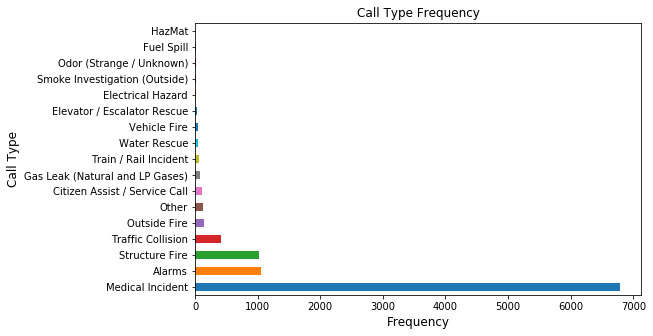

In [6]:
# Plot counts
df['call_type'].value_counts()[:20].plot(kind='barh', figsize=[8,5])
plt.xlabel('Frequency', fontsize = 12)
plt.title('Call Type Frequency')
plt.ylabel('Call Type', fontsize = 12)

#plt.savefig('types.png')
plt.show()

In [7]:
# View values for one row/one emergency call sample  
df.iloc[0]

call_number                                                     180243072
unit_id                                                                84
incident_number                                                  18010216
call_type                                                Medical Incident
call_date                                                      2018-01-24
watch_date                                                     2018-01-24
received_timestamp                         2018-01-24 17:36:16.000000 UTC
entry_timestamp                            2018-01-24 17:38:21.000000 UTC
dispatch_timestamp                         2018-01-24 17:39:41.000000 UTC
response_timestamp                         2018-01-24 17:39:45.000000 UTC
on_scene_timestamp                         2018-01-24 17:53:42.000000 UTC
transport_timestamp                        2018-01-24 18:16:32.000000 UTC
hospital_timestamp                         2018-01-24 18:44:08.000000 UTC
call_final_disposition                

In [8]:
# View values of call_final_disposition
set(df['call_final_disposition'])

{'Against Medical Advice',
 'Cancelled',
 'Code 2 Transport',
 'Code 3 Transport',
 'Fire',
 'Gone on Arrival',
 'Medical Examiner',
 'No Merit',
 'Other',
 'Patient Declined Transport',
 'SFPD',
 'Unable to Locate'}

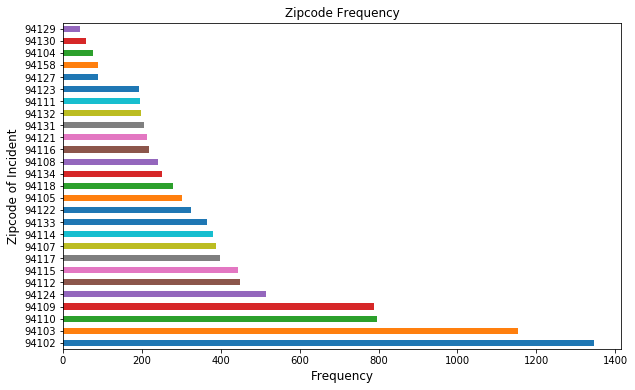

In [9]:
# Plot counts of emergency calls by zipcode
df['zipcode_of_incident'].value_counts()[:30].plot(kind='barh', figsize=[10,6])
plt.xlabel('Frequency', fontsize = 12)
plt.title('Zipcode Frequency')
plt.ylabel('Zipcode of Incident', fontsize = 12)
plt.savefig('assets/zips_freq.png')

In [15]:
df['unit_type'].value_counts()

ENGINE            3589
MEDIC             3066
PRIVATE           1154
TRUCK              981
CHIEF              726
RESCUE CAPTAIN     272
RESCUE SQUAD       168
SUPPORT             33
INVESTIGATION       11
Name: unit_type, dtype: int64

In [16]:
df['call_type'].value_counts()

Medical Incident                   6791
Alarms                             1061
Structure Fire                     1029
Traffic Collision                   410
Outside Fire                        144
Other                               129
Citizen Assist / Service Call       114
Gas Leak (Natural and LP Gases)      86
Train / Rail Incident                55
Water Rescue                         54
Vehicle Fire                         45
Elevator / Escalator Rescue          23
Electrical Hazard                    21
Smoke Investigation (Outside)        15
Fuel Spill                           10
Odor (Strange / Unknown)             10
HazMat                                3
Name: call_type, dtype: int64

In [12]:
type(df['dispatch_timestamp'][0])
# Time columns are strings...not too useful. Let's convert them to Pandas Timestamp objects (equivalent to 
# datetime objects in Python) to be able to perform useful computations (like time differences!)

str

In [13]:
# Make a copy of the dataframe to play with (remove nan neighborhood district column while we're at it)
dfc = df.drop(['neighborhood_district'], axis = 1) 

# Identify time columns
time_columns = ['received_timestamp', 'entry_timestamp', 'dispatch_timestamp', 'response_timestamp', 
                'on_scene_timestamp', 'transport_timestamp', 'hospital_timestamp', 'available_timestamp'] 

# Here we apply a lambda expression to each time column to remove the 'UTC', and then we use the to_datetime 
# function in  pandas to convert the types to python Timestamps instead of strings. 
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Timestamp.html
for col in time_columns:
    dfc[col] = pd.to_datetime(dfc[col].astype(str).apply(lambda x: x[:-3]), format='%Y-%m-%d %H:%M:%S.%f')
dfc.head()

,call_number,unit_id,incident_number,call_type,call_date,watch_date,received_timestamp,entry_timestamp,dispatch_timestamp,response_timestamp,...,call_type_group,number_of_alarms,unit_type,unit_sequence_in_call_dispatch,fire_prevention_district,supervisor_district,location,row_id,latitude,longitude
0,180243072,84,18010216,Medical Incident,2018-01-24,2018-01-24,2018-01-24 17:36:16,2018-01-24 17:38:21,2018-01-24 17:39:41,2018-01-24 17:39:45,...,Non Life-threatening,1,MEDIC,1,7,1,"(37.77444199483868, -122.5046792231959)",180243072-84,37.774442,-122.504679
1,180240538,61,18010011,Medical Incident,2018-01-24,2018-01-23,2018-01-24 07:05:05,2018-01-24 07:05:05,2018-01-24 07:05:31,2018-01-24 07:05:45,...,Non Life-threatening,1,MEDIC,1,2,6,"(37.774094856688166, -122.42000143696421)",180240538-61,37.774095,-122.420001
2,180240176,E22,18009959,Medical Incident,2018-01-24,2018-01-23,2018-01-24 02:04:21,2018-01-24 02:05:37,2018-01-24 02:06:04,2018-01-24 02:07:26,...,Potentially Life-Threatening,1,ENGINE,1,8,7,"(37.75521795168784, -122.47554039050351)",180240176-E22,37.755218,-122.475540
3,180243588,E03,18010271,Alarms,2018-01-24,2018-01-24,2018-01-24 20:04:15,2018-01-24 20:05:12,2018-01-24 20:05:24,2018-01-24 20:05:36,...,Alarm,1,ENGINE,1,4,2,"(37.79031930341935, -122.4231629067995)",180243588-E03,37.790319,-122.423163
4,180243590,B03,18010272,Alarms,2018-01-24,2018-01-24,2018-01-24 20:03:08,2018-01-24 20:05:36,2018-01-24 20:05:57,2018-01-24 20:06:56,...,Alarm,1,CHIEF,3,3,6,"(37.77732776352611, -122.39308855968541)",180243590-B03,37.777328,-122.393089


In [14]:
type(dfc['dispatch_timestamp'][0])
# Great! This allows us to perform new operations.

pandas._libs.tslib.Timestamp

In [16]:
# Test  
# Create a new pandas column that is the time difference (timedelta) between received_timestamp and dispatch timestamp
dfc['received_to_dispatch'] = dfc['dispatch_timestamp'] - dfc['received_timestamp']
dfc['received_to_dispatch'].head()

0   00:03:25
1   00:00:26
2   00:01:43
3   00:01:09
4   00:02:49
Name: received_to_dispatch, dtype: timedelta64[ns]

In [19]:
"""
Function min_timedelta
Get the time differential in seconds between two TimeStamp objects. 
Args:
    t1: This is the time that occured first. 
    t2: This is the time that occured after t1. 
Returns: The timedelta in float minutes. 
"""
def min_timedelta(t1, t2): 
    return (t2 - t1).seconds/60

print (seconds_timedelta(dfc['dispatch_timestamp'][0], dfc['received_timestamp'][0]))

1436.5833333333333


In [20]:
# Create new columns
# timedelta of time call is received at the 911 Dispatch Center, and time the 911 operator dispatches a unit to call.
dfc['received_to_dispatch'] = dfc['dispatch_timestamp'] - dfc['received_timestamp']
dfc['received_to_dispatch'] = dfc['received_to_dispatch'].apply(lambda x: x.seconds/60)

# timedelta of time call is received at the 911 Dispatch Center, and time the 911 operator arrives on scene.
dfc['received_to_onscene'] = dfc['on_scene_timestamp'] - dfc['received_timestamp']
dfc['received_to_onscene'] = dfc['received_to_onscene'].apply(lambda x: x.seconds/60)

In [22]:
# View descriptive statistics for new column, the response time in minutes
dfc['received_to_dispatch'].describe()

count    10000.000000
mean         3.752545
std         20.183932
min          0.000000
25%          1.216667
50%          2.000000
75%          3.083333
max        754.083333
Name: received_to_dispatch, dtype: float64

In [23]:
print (dfc['received_to_onscene'].describe())

count    8085.000000
mean        9.989967
std        17.115195
min         0.000000
25%         5.500000
50%         7.366667
75%        11.083333
max       763.983333
Name: received_to_onscene, dtype: float64


In [25]:
# Max seems to be an outlier...let's see the 99th percentile
dfc['received_to_onscene'].quantile(0.99) 
# It's definitely an outlier

37.624666666666656

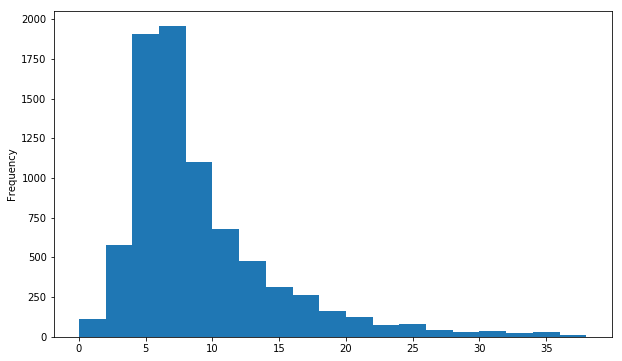

In [26]:
# Quick check of distribution of response time
dfc['received_to_onscene'].plot(kind='hist', bins = np.arange(start=0, stop=40, step=2), figsize=[10,6])
# `bins` defines the start and end points of bins, np.arange creates a list [0, 100,...2000]

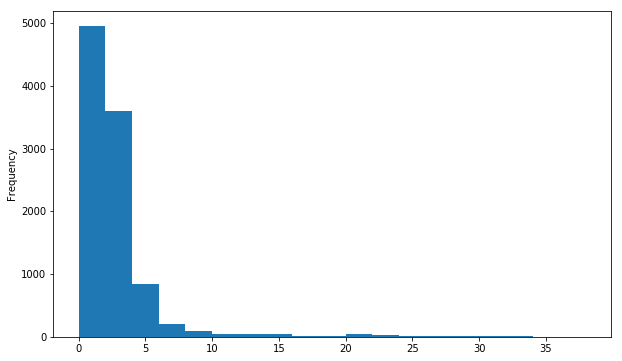

In [27]:
dfc['received_to_dispatch'].plot(kind='hist', bins = np.arange(start=0, stop=40, step=2), figsize=[10,6])

We now have the useful statistic of response time and more, and can calculate typical/average values for different groupings as we please. However, its important to note that by its very nature this dataset can contain extreme outliers-emergencies can be highly variant- and so it would be useful to compute both means (sensitive to outliers) and medians(robust to outliers) in our analysis. 

In [29]:
# Compute average response time for each zip code 
"""
Function get_group_averages
Get the average by desired grouping of a desired statistic, ex: average time to arrive for each zipcode. 
Args:
    df: DataFrame object to use for calculation.
    group_by_feature: String representing the feature you want to group by, ex: 'zipcode_of_incident'
    value: String representing the feature you want to average for each group, ex: 'received_to_onscene' 
Returns: A list of tuples (group, avg_value) sorted by the value averages for each grouping. 
"""
def get_group_averages(df, group_by_feature: str, value: str): 
    d = {}
    for each in set(df[group_by_feature].values): 
        d[each] = np.nanmean(df[df[group_by_feature] == each][value]) # was np.nanmean
    return sorted(d.items(), key=operator.itemgetter(1), reverse = True)

# Same as above, but computes median instead
def get_group_median(df, group_by_feature: str, value: str): 
    d = {}
    for each in set(df[group_by_feature].values): 
        d[each] = np.nanmedian(df[df[group_by_feature] == each][value]) # was np.nanmean
    return sorted(d.items(), key=operator.itemgetter(1), reverse = True)

In [74]:
"""
Function get_sorted_bar
Get a bargraph with sorted averages, using list of tuples created by get_group_averages. 
Args:
    group_averages: list of tuples (group, avg_value)
    filename: string name desired for filename and plot 
    zipcode: Plotting zipcodes? Default false, as zipcode labels need more space on x-axis, this sets larger plotsize
Returns: Outputs and saves the bar plot (returns None)
"""

def get_sorted_bar(group_averages, filename: str, zipcode = False): 
    group_averages = [x for x in group_averages if x[0] != 'None']
    X = [x[0] for x in group_averages]
    Y = [x[1] for x in group_averages]

    if zip: 
        plt.figure(figsize=(20,10))
    else: 
        plt.figure(figsize=(10,5))
    plt.bar(range(len(group_averages)), Y)
    plt.xticks(range(len(group_averages)), X)
    plt.xlabel('Time in Minutes')
    plt.title(filename)
#     plt.savefig('Medians/' + filename + '.png')

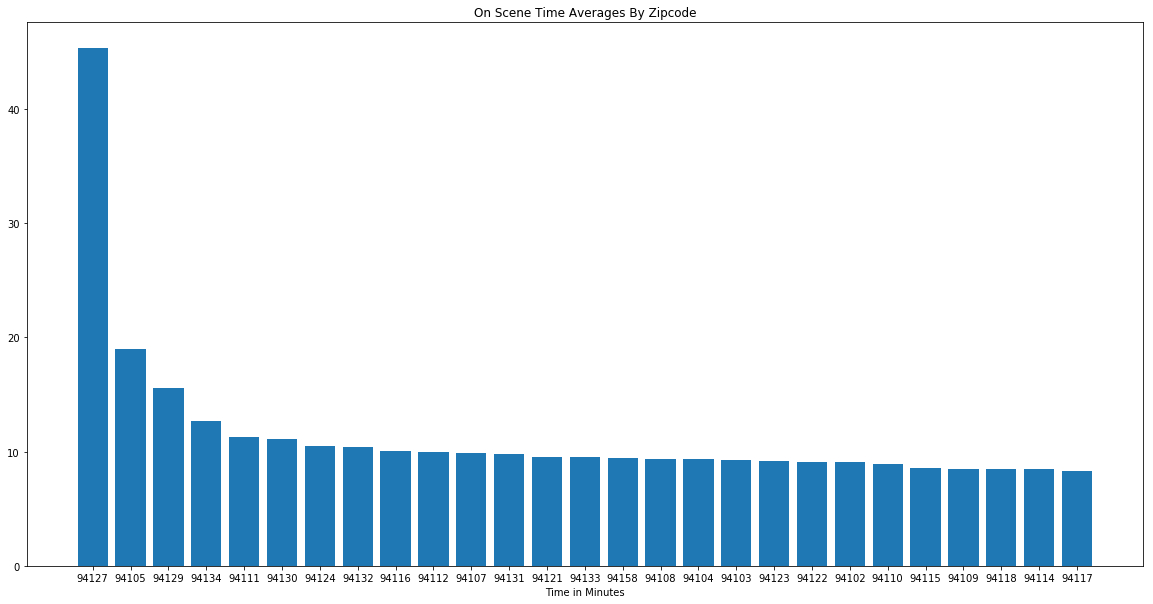

In [75]:
avg_received_onscene_time = get_group_averages(dfc, 'zipcode_of_incident', 'received_to_onscene')
get_sorted_bar(avg_received_onscene_time, 'On Scene Time Averages By Zipcode', zipcode = True)

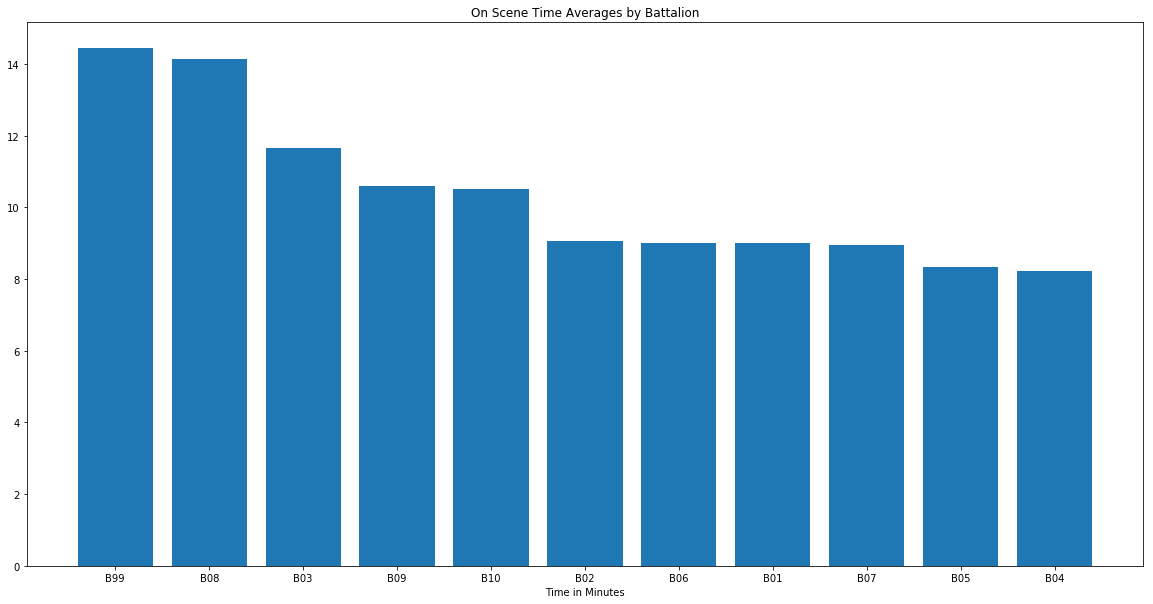

In [76]:
battalion_avgs_onscene = get_group_averages(dfc, 'battalion', 'received_to_onscene')
get_sorted_bar(battalion_avgs_onscene, 'On Scene Time Averages by Battalion')

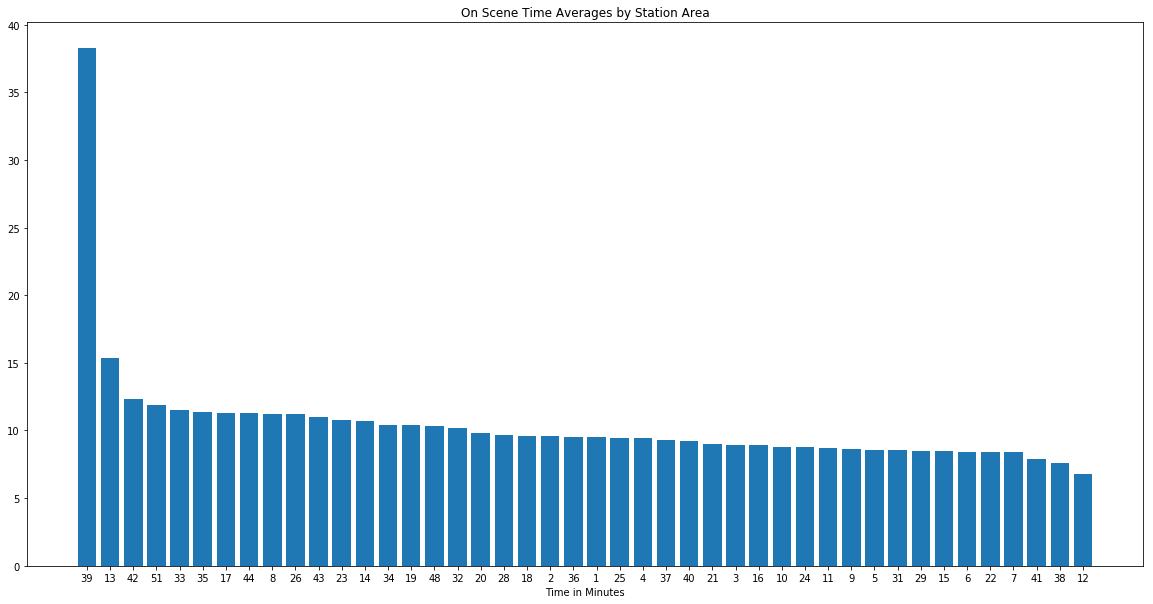

In [59]:
station_area_avgs_onscene = get_group_averages(dfc, 'station_area', 'received_to_onscene')
get_sorted_bar(station_area_avgs_onscene, 'On Scene Time Averages by Station Area')

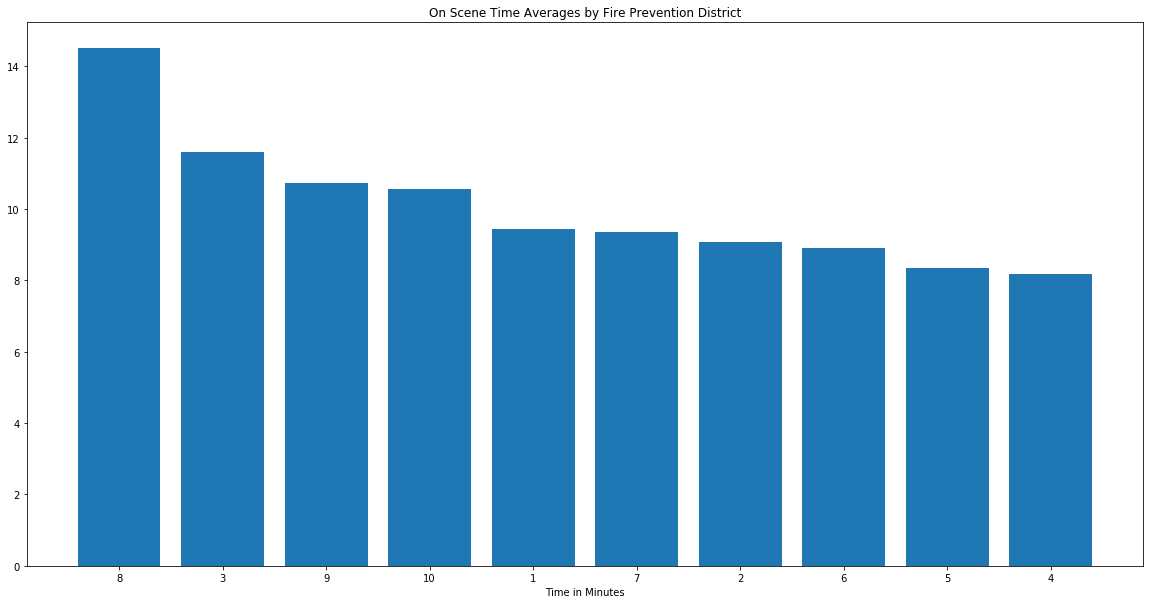

In [60]:
fire_prevention_district_avgs_onscene = get_group_averages(dfc, 'fire_prevention_district', 'received_to_onscene')
get_sorted_bar(fire_prevention_district_avgs_onscene, 'On Scene Time Averages by Fire Prevention District')

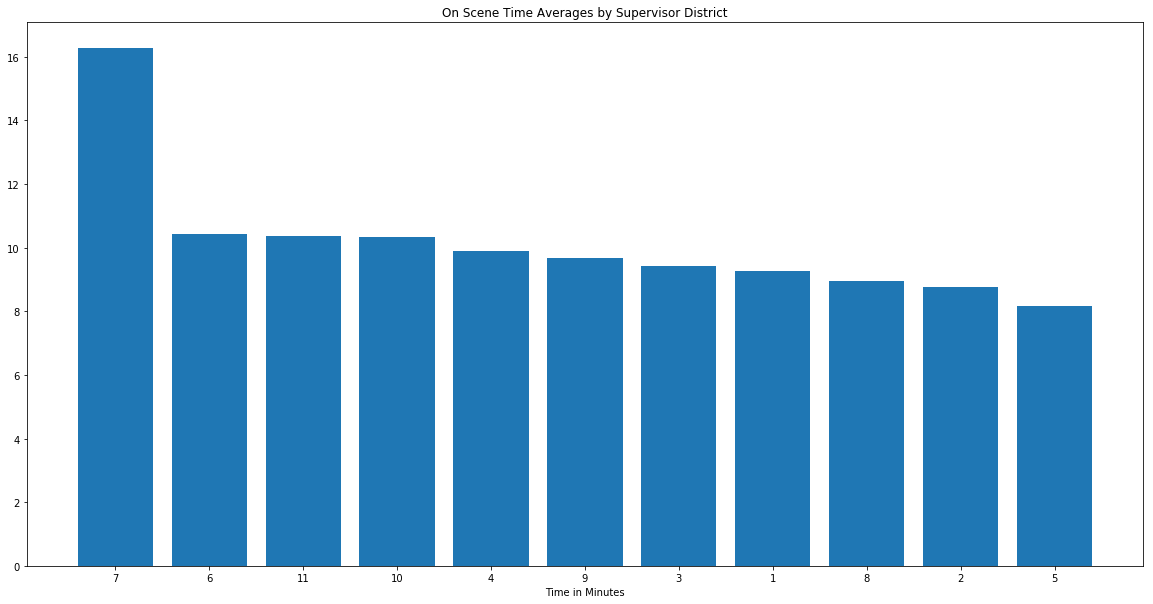

In [61]:
supervisor_district_avgs_onscene = get_group_averages(dfc, 'supervisor_district', 'received_to_onscene')
get_sorted_bar(supervisor_district_avgs_onscene, 'On Scene Time Averages by Supervisor District')

C:\Users\shami\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


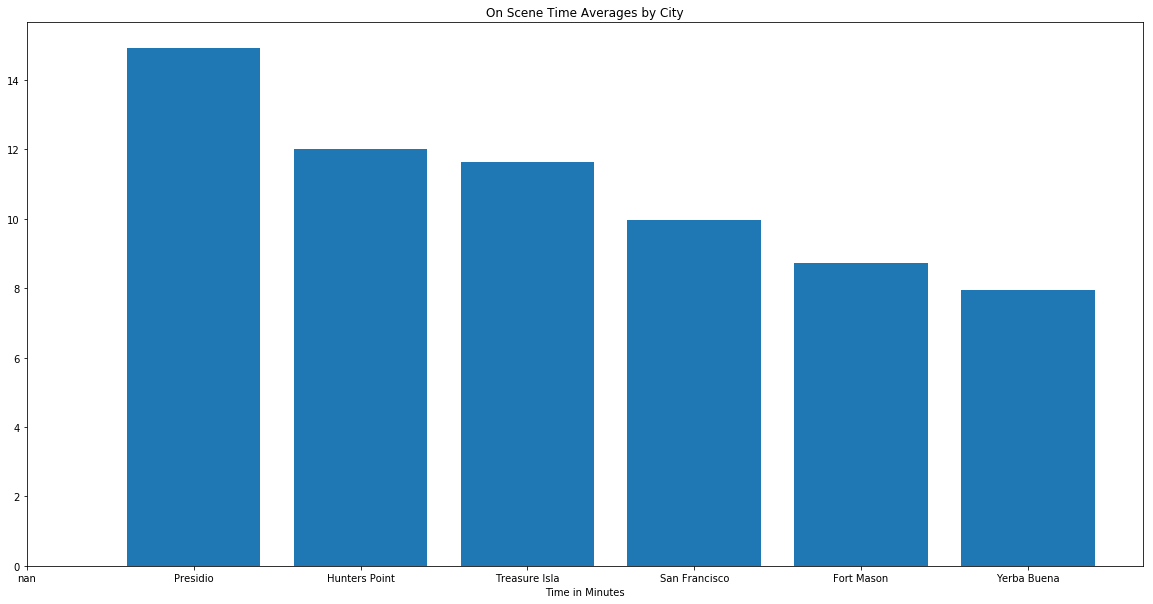

In [62]:
city_avgs_onscene = get_group_averages(dfc, 'city', 'received_to_onscene')
get_sorted_bar(city_avgs_onscene, 'On Scene Time Averages by City')

In [63]:
supervisor_district_avgs_onscene

[(7, 16.269975490196078),
 (6, 10.415100278143758),
 (11, 10.364382139148494),
 (10, 10.320663153271848),
 (4, 9.89343607305936),
 (9, 9.686557462298493),
 (3, 9.41461318051576),
 (1, 9.254863221884499),
 (8, 8.957093765341188),
 (2, 8.761578604044358),
 (5, 8.156211936662606)]

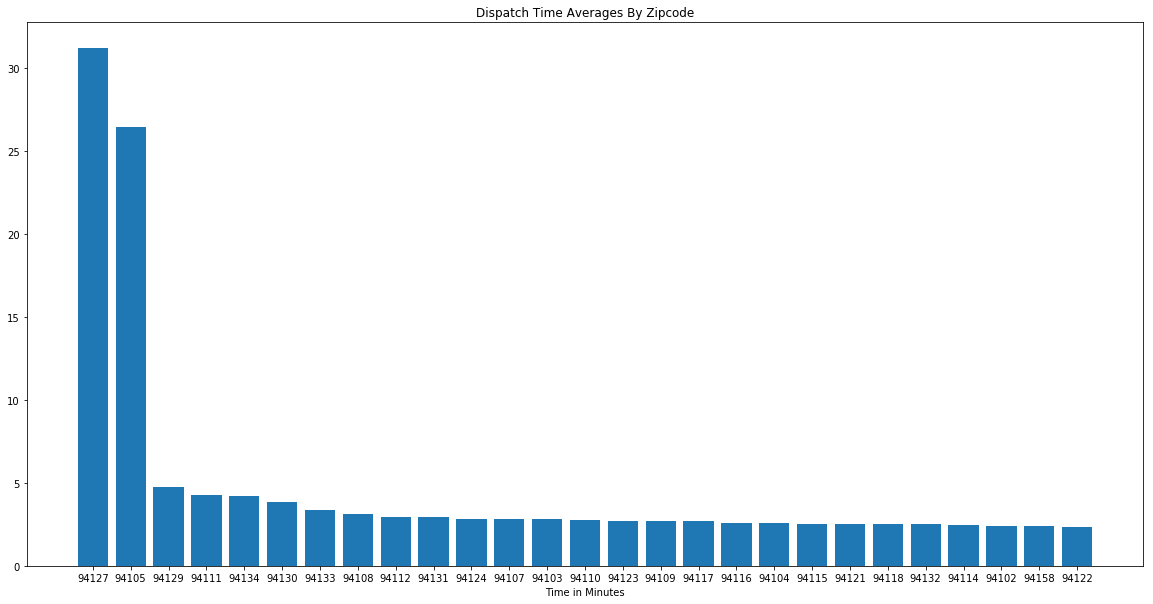

In [64]:
# Now let's see times to dispatch
zip_received_dispatch_time = get_group_averages(dfc, 'zipcode_of_incident', 'received_to_dispatch')
get_sorted_bar(zip_received_dispatch_time, 'Dispatch Time Averages By Zipcode', zipcode = True)

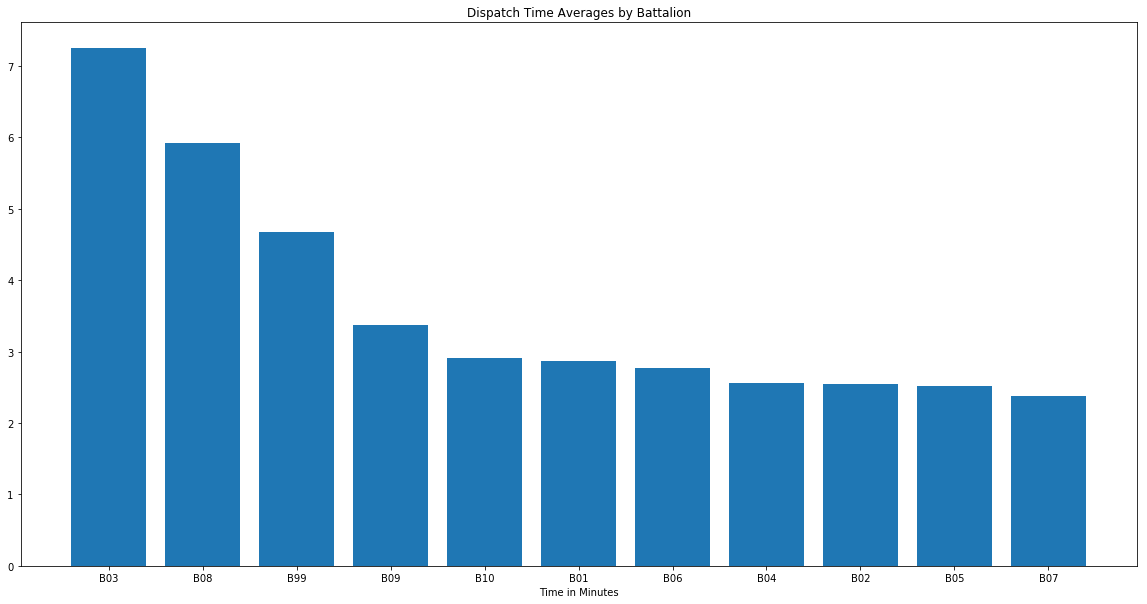

In [77]:
battalion_avgs_dispatch = get_group_averages(dfc, 'battalion', 'received_to_dispatch')
get_sorted_bar(battalion_avgs_dispatch, 'Dispatch Time Averages by Battalion')

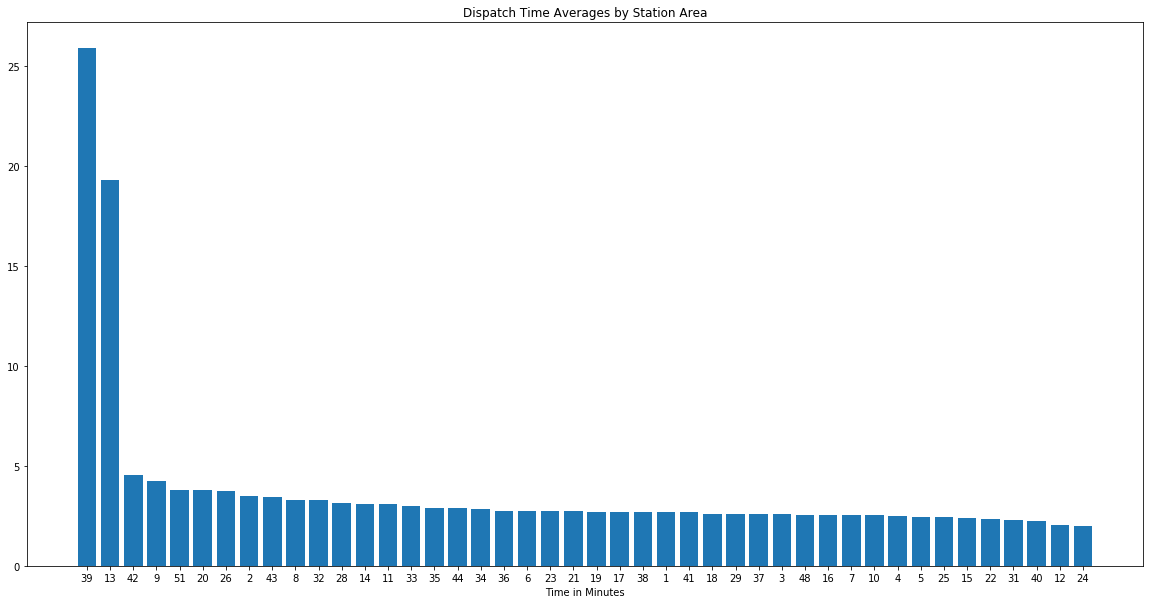

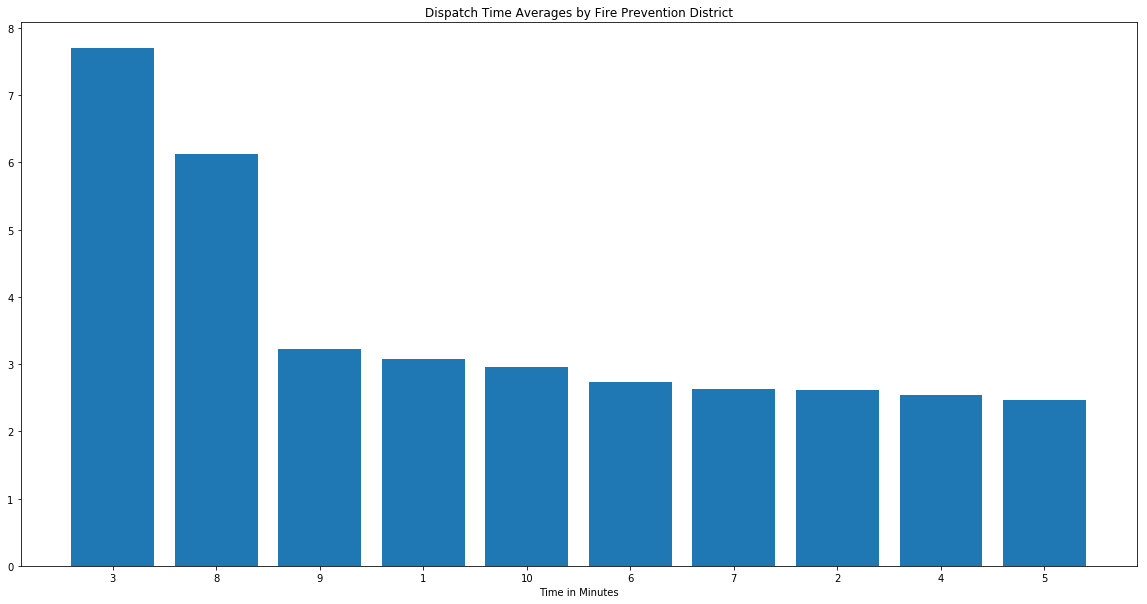

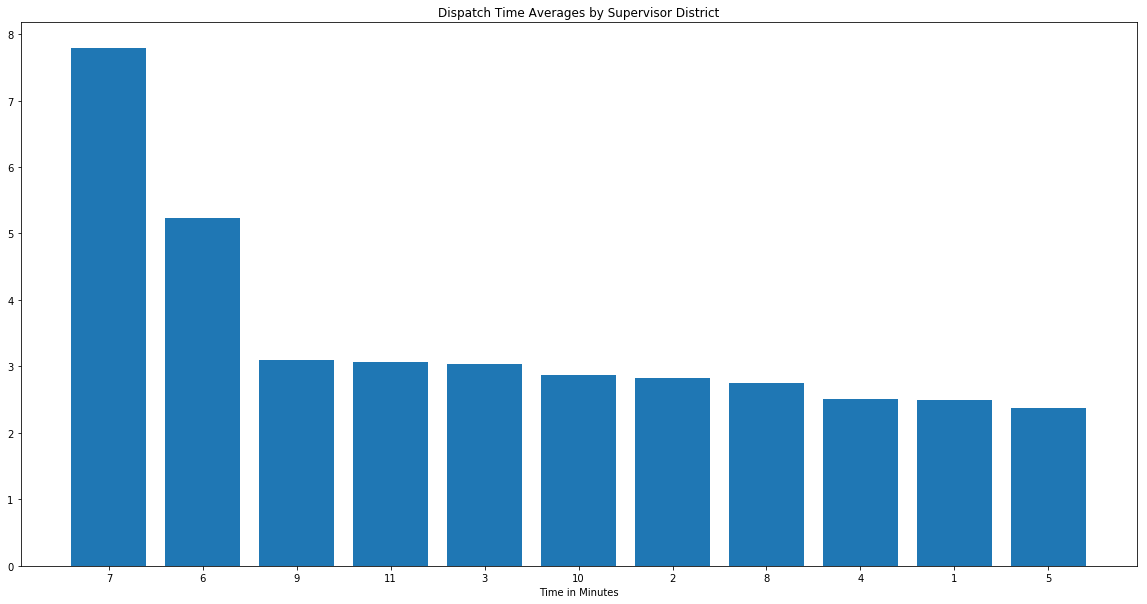

In [78]:
station_area_avgs_dispatch = get_group_averages(dfc, 'station_area', 'received_to_dispatch')
get_sorted_bar(station_area_avgs_dispatch, 'Dispatch Time Averages by Station Area')

fire_prevention_district_avgs_dispatch = get_group_averages(dfc, 'fire_prevention_district', 'received_to_dispatch')
get_sorted_bar(fire_prevention_district_avgs_dispatch, 'Dispatch Time Averages by Fire Prevention District')

supervisor_district_avgs_dispatch = get_group_averages(dfc, 'supervisor_district', 'received_to_dispatch')
get_sorted_bar(supervisor_district_avgs_dispatch, 'Dispatch Time Averages by Supervisor District')

C:\Users\shami\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


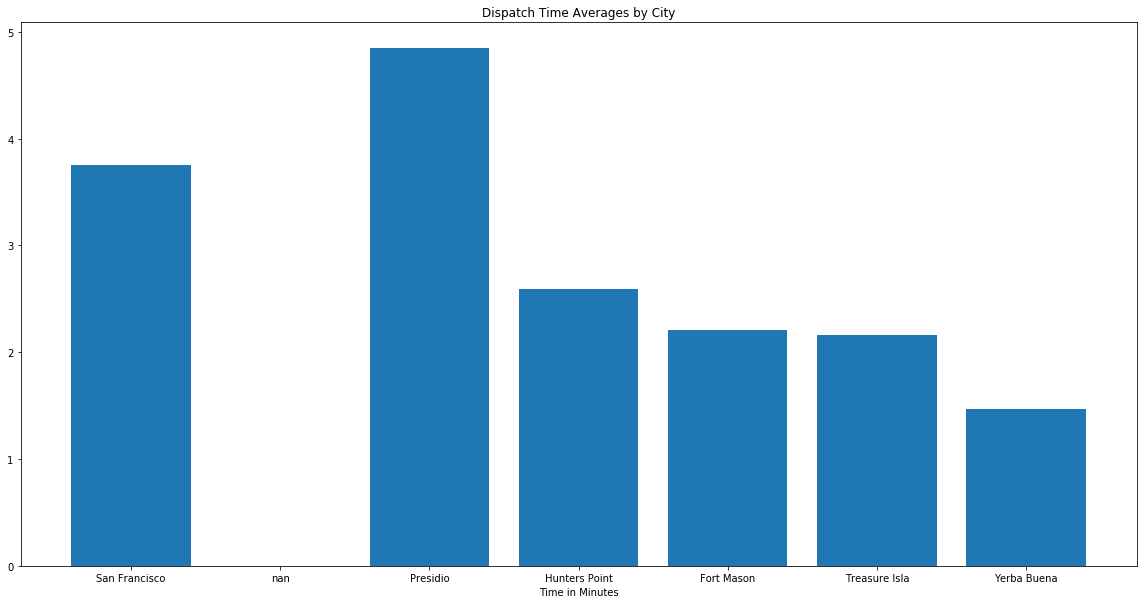

In [80]:
city_avgs_dispatch = get_group_averages(dfc, 'city', 'received_to_dispatch')
get_sorted_bar(city_avgs_dispatch, 'Dispatch Time Averages by City')

In [38]:
# We can now answer: Which areas take the longest time to dispatch to on average? 
# Zipcode 94129, Batallion B99, City Presidio, Station Areas 51, 20

In [67]:
# Get longest time areas
top_onscene = {'avg_received_onscene_time' : avg_received_onscene_time[:4], 'battalion_avgs_onscene' : battalion_avgs_onscene[:4],
               'station_area_avgs_onscene' : station_area_avgs_onscene[:4], 
               'fire_prevention_district_avgs_onscene': fire_prevention_district_avgs_onscene[:4],
               'supervisor_district_avgs_onscene' : supervisor_district_avgs_onscene[:4], 
               'city_avgs_onscene': city_avgs_onscene[:4]}

top_dispatch = {'zip_received_dispatch_time' : zip_received_dispatch_time[:4], 'battalion_avgs_dispatch' : battalion_avgs_dispatch[:4],
               'station_area_avgs_dispatch' : station_area_avgs_dispatch[:4], 
               'fire_prevention_district_avgs_dispatch': fire_prevention_district_avgs_dispatch[:4],
               'supervisor_district_avgs_dispatch' : supervisor_district_avgs_dispatch[:4], 
               'city_avgs_dispatch': city_avgs_dispatch[:4]}

In [71]:
print (top_onscene)
print (top_dispatch)

{'avg_received_onscene_time': [(94127, 45.32510548523208), (94105, 19.0234984984985), (94129, 15.558620689655172), (94134, 12.700829187396351)], 'battalion_avgs_onscene': [('B99', 14.441346153846155), ('B08', 14.15036861506056), ('B03', 11.661950165268243), ('B09', 10.603793103448277)], 'station_area_avgs_onscene': [(39, 38.264089347079036), (13, 15.32307307307307), (42, 12.327258566978195), (51, 11.913425925925928)], 'fire_prevention_district_avgs_onscene': [('8', 14.508879551820728), ('3', 11.585772713993572), ('9', 10.719055843408176), ('10', 10.557799304520616)], 'supervisor_district_avgs_onscene': [(7, 16.269975490196078), (6, 10.415100278143758), (11, 10.364382139148494), (10, 10.320663153271848)], 'city_avgs_onscene': [(nan, nan), ('Presidio', 14.91701388888889), ('Hunters Point', 12.005555555555558), ('Treasure Isla', 11.625)]}
{'zip_received_dispatch_time': [(94127, 31.179259259259258), (94105, 26.438393839383938), (94129, 4.720454545454545), (94111, 4.245918367346939)], 'batt

In [82]:
# View the call type distribution of all incidents in zipcode 94127
# normalize lets us view proportions
dfc[dfc['zipcode_of_incident'] == 94127]['call_type'].value_counts(normalize = True)
# Mostly medical incidents! 

Structure Fire                   0.555556
Medical Incident                 0.355556
Alarms                           0.033333
Traffic Collision                0.022222
Other                            0.022222
Citizen Assist / Service Call    0.011111
Name: call_type, dtype: float64

In [83]:
dfc[dfc['zipcode_of_incident'] == 94127]['unit_type'].value_counts(normalize = True)

ENGINE            0.422222
MEDIC             0.200000
CHIEF             0.111111
TRUCK             0.100000
PRIVATE           0.066667
SUPPORT           0.033333
RESCUE SQUAD      0.033333
RESCUE CAPTAIN    0.022222
INVESTIGATION     0.011111
Name: unit_type, dtype: float64

In [46]:
dfc[dfc['zipcode_of_incident'] == 94105]['call_type'].value_counts(normalize = True)

Medical Incident                 0.557756
Alarms                           0.198020
Train / Rail Incident            0.135314
Structure Fire                   0.042904
Traffic Collision                0.023102
Outside Fire                     0.009901
Smoke Investigation (Outside)    0.009901
Citizen Assist / Service Call    0.009901
Vehicle Fire                     0.006601
Other                            0.006601
Name: call_type, dtype: float64

In [47]:
dfc[dfc['zipcode_of_incident'] == 94105]['unit_type'].value_counts(normalize = True)

ENGINE            0.339934
MEDIC             0.231023
TRUCK             0.141914
PRIVATE           0.118812
CHIEF             0.108911
RESCUE CAPTAIN    0.026403
RESCUE SQUAD      0.026403
SUPPORT           0.003300
INVESTIGATION     0.003300
Name: unit_type, dtype: float64

In [48]:
dfc[dfc['supervisor_district'] == 7]['call_type'].value_counts(normalize = True)

Medical Incident                   0.621399
Structure Fire                     0.174897
Alarms                             0.119342
Citizen Assist / Service Call      0.022634
Water Rescue                       0.018519
Other                              0.016461
Traffic Collision                  0.012346
Gas Leak (Natural and LP Gases)    0.006173
Outside Fire                       0.004115
Electrical Hazard                  0.002058
Elevator / Escalator Rescue        0.002058
Name: call_type, dtype: float64

In [49]:
dfc[dfc['supervisor_district'] == 7]['unit_type'].value_counts(normalize = True)

ENGINE            0.390947
MEDIC             0.298354
TRUCK             0.094650
PRIVATE           0.084362
CHIEF             0.084362
RESCUE CAPTAIN    0.020576
RESCUE SQUAD      0.014403
SUPPORT           0.010288
INVESTIGATION     0.002058
Name: unit_type, dtype: float64

In [51]:
dfc['call_type'].value_counts()

Medical Incident                   6791
Alarms                             1061
Structure Fire                     1029
Traffic Collision                   410
Outside Fire                        144
Other                               129
Citizen Assist / Service Call       114
Gas Leak (Natural and LP Gases)      86
Train / Rail Incident                55
Water Rescue                         54
Vehicle Fire                         45
Elevator / Escalator Rescue          23
Electrical Hazard                    21
Smoke Investigation (Outside)        15
Fuel Spill                           10
Odor (Strange / Unknown)             10
HazMat                                3
Name: call_type, dtype: int64

In [52]:
dfc['zipcode_of_incident'].value_counts()

94102    1347
94103    1153
94110     796
94109     788
94124     514
94112     449
94115     444
94117     398
94107     387
94114     380
94133     366
94122     324
94105     303
94118     280
94134     250
94108     241
94116     218
94121     214
94131     205
94132     199
94111     196
94123     192
94127      90
94158      88
94104      75
94130      59
94129      44
Name: zipcode_of_incident, dtype: int64

In [53]:
dfc['station_area'].value_counts()

3     1213
1      814
36     652
6      472
13     442
7      413
17     353
5      344
28     258
2      249
41     243
11     242
35     231
21     230
38     216
10     211
15     206
8      204
43     201
16     181
32     178
31     164
12     159
44     157
18     157
33     141
29     140
14     134
42     131
22     127
40     122
19     111
39     110
23     108
37     102
34      84
24      82
9       81
26      78
4       74
25      58
51      57
48      44
20      26
Name: station_area, dtype: int64

In [54]:
dfc[dfc['zipcode_of_incident'] == 94129]['call_type'].value_counts(normalize = True)
# Safest- 94129, Presidio (Battalion B99), Treasure Island, 94130

Water Rescue        0.431818
Medical Incident    0.340909
Alarms              0.227273
Name: call_type, dtype: float64

In [55]:
dfc[dfc['zipcode_of_incident'] == 94130]['call_type'].value_counts(normalize = True)

Medical Incident                 0.508475
Other                            0.237288
Traffic Collision                0.169492
Alarms                           0.050847
Citizen Assist / Service Call    0.016949
Outside Fire                     0.016949
Name: call_type, dtype: float64

In [56]:
dfc[dfc['station_area'] == 20]['zipcode_of_incident'].value_counts(normalize = True)

94131    0.884615
94116    0.076923
94122    0.038462
Name: zipcode_of_incident, dtype: float64

In [57]:
# Place with least amount of alarms (burglaries etc) is indicative of safe place
dfc[dfc['call_type'] == 'Alarms']['zipcode_of_incident'].value_counts(normalize = True)
# Presidio again! 

94102    0.139491
94103    0.090481
94110    0.070688
94109    0.066918
94108    0.064090
94115    0.062205
94105    0.056550
94107    0.053723
94133    0.041470
94114    0.039585
94117    0.030160
94132    0.029218
94121    0.027333
94123    0.027333
94122    0.026390
94124    0.026390
94131    0.026390
94118    0.023563
94112    0.019793
94158    0.016965
94134    0.015080
94111    0.014138
94116    0.011310
94129    0.009425
94104    0.005655
94127    0.002828
94130    0.002828
Name: zipcode_of_incident, dtype: float64

In [85]:
# Create new feature columns of hour the call was received, and the day of the week it was received
dfc['hour'] = dfc['received_timestamp'].apply(lambda x: x.hour)
dfc['day'] = dfc['received_timestamp'].apply(lambda x: x.weekday_name)
dfc.head()

,call_number,unit_id,incident_number,call_type,call_date,watch_date,received_timestamp,entry_timestamp,dispatch_timestamp,response_timestamp,...,fire_prevention_district,supervisor_district,location,row_id,latitude,longitude,received_to_dispatch,received_to_onscene,hour,day
0,180243072,84,18010216,Medical Incident,2018-01-24,2018-01-24,2018-01-24 17:36:16,2018-01-24 17:38:21,2018-01-24 17:39:41,2018-01-24 17:39:45,...,7,1,"(37.77444199483868, -122.5046792231959)",180243072-84,37.774442,-122.504679,3.416667,17.433333,17,Wednesday
1,180240538,61,18010011,Medical Incident,2018-01-24,2018-01-23,2018-01-24 07:05:05,2018-01-24 07:05:05,2018-01-24 07:05:31,2018-01-24 07:05:45,...,2,6,"(37.774094856688166, -122.42000143696421)",180240538-61,37.774095,-122.420001,0.433333,13.950000,7,Wednesday
2,180240176,E22,18009959,Medical Incident,2018-01-24,2018-01-23,2018-01-24 02:04:21,2018-01-24 02:05:37,2018-01-24 02:06:04,2018-01-24 02:07:26,...,8,7,"(37.75521795168784, -122.47554039050351)",180240176-E22,37.755218,-122.475540,1.716667,5.683333,2,Wednesday
3,180243588,E03,18010271,Alarms,2018-01-24,2018-01-24,2018-01-24 20:04:15,2018-01-24 20:05:12,2018-01-24 20:05:24,2018-01-24 20:05:36,...,4,2,"(37.79031930341935, -122.4231629067995)",180243588-E03,37.790319,-122.423163,1.150000,4.033333,20,Wednesday
4,180243590,B03,18010272,Alarms,2018-01-24,2018-01-24,2018-01-24 20:03:08,2018-01-24 20:05:36,2018-01-24 20:05:57,2018-01-24 20:06:56,...,3,6,"(37.77732776352611, -122.39308855968541)",180243590-B03,37.777328,-122.393089,2.816667,6.116667,20,Wednesday


In [86]:
"""
Function assign_day_portion
Assigns categorical values to hour call was received to get a new feature representing a chunk of the 24-hr day. 
Args:
    x: The hour the call was received
Returns: The portion of the day, divided into Night Hours, Morning to Late Afternoon, and Evening to Midnight, 
in which the call was received.
"""
def assign_day_portion(x): 
    if (x >= 0 and x <= 7) or (x == 24): # 0:00 to 7:00 (AM) - Night Hours
        return '12 AM to 7 AM' 
    if x >= 8 and x <= 15: # 8 AM to 3 PM - Morning to Late Afternoon
        return '8 AM to 3 PM'
    if x >= 16 and x < 24: # 4 PM to 11 PM - Evening to Midnight
        return '4 PM to 11 PM'
    
dfc['day_portion'] = dfc['hour'].apply(assign_day_portion)
dfc.head()

,call_number,unit_id,incident_number,call_type,call_date,watch_date,received_timestamp,entry_timestamp,dispatch_timestamp,response_timestamp,...,supervisor_district,location,row_id,latitude,longitude,received_to_dispatch,received_to_onscene,hour,day,day_portion
0,180243072,84,18010216,Medical Incident,2018-01-24,2018-01-24,2018-01-24 17:36:16,2018-01-24 17:38:21,2018-01-24 17:39:41,2018-01-24 17:39:45,...,1,"(37.77444199483868, -122.5046792231959)",180243072-84,37.774442,-122.504679,3.416667,17.433333,17,Wednesday,4 PM to 11 PM
1,180240538,61,18010011,Medical Incident,2018-01-24,2018-01-23,2018-01-24 07:05:05,2018-01-24 07:05:05,2018-01-24 07:05:31,2018-01-24 07:05:45,...,6,"(37.774094856688166, -122.42000143696421)",180240538-61,37.774095,-122.420001,0.433333,13.950000,7,Wednesday,12 AM to 7 AM
2,180240176,E22,18009959,Medical Incident,2018-01-24,2018-01-23,2018-01-24 02:04:21,2018-01-24 02:05:37,2018-01-24 02:06:04,2018-01-24 02:07:26,...,7,"(37.75521795168784, -122.47554039050351)",180240176-E22,37.755218,-122.475540,1.716667,5.683333,2,Wednesday,12 AM to 7 AM
3,180243588,E03,18010271,Alarms,2018-01-24,2018-01-24,2018-01-24 20:04:15,2018-01-24 20:05:12,2018-01-24 20:05:24,2018-01-24 20:05:36,...,2,"(37.79031930341935, -122.4231629067995)",180243588-E03,37.790319,-122.423163,1.150000,4.033333,20,Wednesday,4 PM to 11 PM
4,180243590,B03,18010272,Alarms,2018-01-24,2018-01-24,2018-01-24 20:03:08,2018-01-24 20:05:36,2018-01-24 20:05:57,2018-01-24 20:06:56,...,6,"(37.77732776352611, -122.39308855968541)",180243590-B03,37.777328,-122.393089,2.816667,6.116667,20,Wednesday,4 PM to 11 PM


In [60]:
# Which hours had the highest proportion of emergency calls in the month of January?
dfc['hour'].value_counts(normalize = True)

16    0.0595
12    0.0588
15    0.0577
19    0.0549
14    0.0536
18    0.0521
10    0.0517
11    0.0511
13    0.0506
17    0.0503
9     0.0502
20    0.0487
22    0.0441
21    0.0383
23    0.0364
8     0.0348
2     0.0304
0     0.0304
7     0.0303
1     0.0283
6     0.0256
4     0.0224
3     0.0205
5     0.0193
Name: hour, dtype: float64

In [61]:
dfc['day_portion'].value_counts()

8 AM to 3 PM     4085
4 PM to 11 PM    3843
12 AM to 7 AM    2072
Name: day_portion, dtype: int64

In [62]:
# Most common call types for each time range
portions = ['8 AM to 3 PM', '4 PM to 11 PM' , '12 AM to 7 AM']
for portion in portions: 
    print ('Most common call type for', portion)
    print (dfc[dfc['day_portion'] == portion]['call_type'].value_counts(normalize = True)[:3])

Most common call type for 8 AM to 3 PM
Medical Incident    0.671726
Alarms              0.118482
Structure Fire      0.095226
Name: call_type, dtype: float64
Most common call type for 4 PM to 11 PM
Medical Incident    0.675254
Structure Fire      0.109810
Alarms              0.105647
Name: call_type, dtype: float64
Most common call type for 12 AM to 7 AM
Medical Incident    0.700772
Structure Fire      0.105212
Alarms              0.082529
Name: call_type, dtype: float64


In [87]:
# How about for every hour?
for x in np.arange(0, 24, 1): 
    print (x, dfc[dfc['hour'] == x]['call_type'].value_counts(normalize = True)[:2])
# Medical Incidents are the most common calls at every hour of the day...

0 Medical Incident    0.773026
Alarms              0.082237
Name: call_type, dtype: float64
1 Medical Incident    0.756184
Alarms              0.084806
Name: call_type, dtype: float64
2 Medical Incident    0.664474
Structure Fire      0.174342
Name: call_type, dtype: float64
3 Medical Incident    0.809756
Alarms              0.073171
Name: call_type, dtype: float64
4 Medical Incident    0.575893
Alarms              0.156250
Name: call_type, dtype: float64
5 Medical Incident    0.652850
Structure Fire      0.129534
Name: call_type, dtype: float64
6 Medical Incident    0.687500
Structure Fire      0.136719
Name: call_type, dtype: float64
7 Medical Incident    0.673267
Structure Fire      0.125413
Name: call_type, dtype: float64
8 Medical Incident    0.701149
Alarms              0.112069
Name: call_type, dtype: float64
9 Medical Incident    0.739044
Alarms              0.121514
Name: call_type, dtype: float64
10 Medical Incident    0.636364
Alarms              0.131528
Name: call_type, dt

In [88]:
# New feature - difference between when the operator dispatches the unit and when unit reports that it is en route 
# (We can check if there is a time of day in which this is more sluggish?)
dfc['dispatch_to_response'] = dfc['response_timestamp'] - dfc['dispatch_timestamp']
dfc['dispatch_to_response'] = dfc['dispatch_to_response'].apply(lambda x: x.seconds/60)

dfc['response_to_onscene'] = dfc['on_scene_timestamp'] - dfc['response_timestamp']
dfc['response_to_onscene'] = dfc['response_to_onscene'].apply(lambda x: x.seconds/60)

(array([1344., 1156.,  547.,  295.,  398.,  412.,  329.,  311.,  340.,
         357.,  375.,  486.,  298.,  441.,  293.,  272.,  277.,  227.,
         284.,  152.,  152.,  129.,  130.,  108.,   84.,   67.,   46.,
          47.,   27.,   33.,   29.,   26.,   22.,   16.,   15.,   19.,
          15.,   17.,    7.,    6.,    7.,   10.,   15.,    5.,    6.,
           5.,    3.,    6.,    5.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
 <a list of 49 Patch objects>)

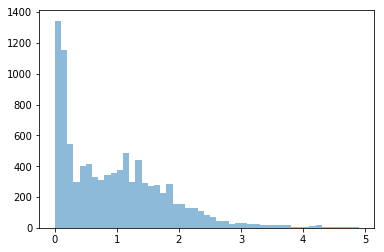

In [89]:
# Quick plot of the distribution
plt.hist(dfc['dispatch_to_response'].dropna(), alpha = .5, bins = np.arange(0, 5, .1), label='dispatch_to_response')

In [67]:
# Is there a time in the day officers are more sluggish in responding to dispatches?
# Let's see descriptive statistics for each day portion
dfc[dfc['day_portion'] == '8 AM to 3 PM']['dispatch_to_response'].describe()

count    3980.000000
mean        1.253153
std        22.787279
min         0.000000
25%         0.200000
50%         0.700000
75%         1.300000
max      1437.266667
Name: dispatch_to_response, dtype: float64

In [68]:
dfc[dfc['day_portion'] == '4 PM to 11 PM']['dispatch_to_response'].describe()

count    3736.000000
mean        0.943616
std         1.036905
min         0.000000
25%         0.166667
50%         0.833333
75%         1.400000
max        25.200000
Name: dispatch_to_response, dtype: float64

In [69]:
dfc[dfc['day_portion'] == '12 AM to 7 AM']['dispatch_to_response'].describe()

count    2023.000000
mean        1.413182
std         1.867278
min         0.000000
25%         0.216667
50%         1.233333
75%         1.966667
max        31.666667
Name: dispatch_to_response, dtype: float64

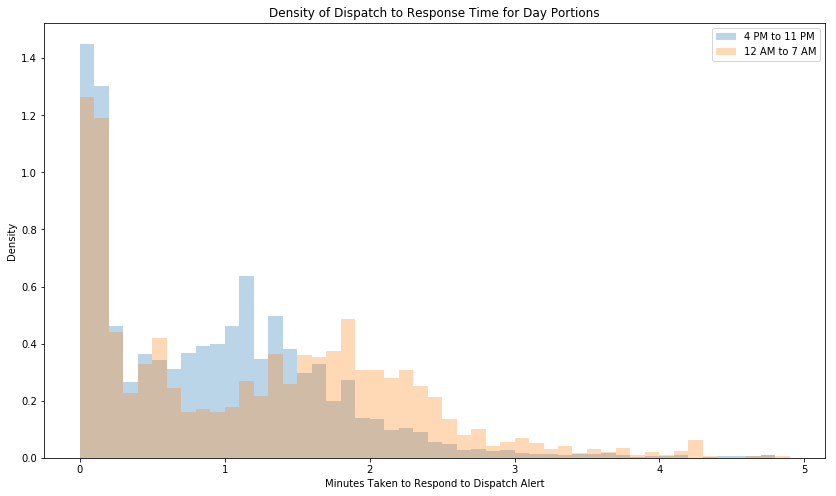

In [70]:
# Plot distributions of two day portions to compare them
x = dfc[dfc['day_portion'] == '4 PM to 11 PM']['dispatch_to_response'].dropna()
y = dfc[dfc['day_portion'] == '12 AM to 7 AM']['dispatch_to_response'].dropna()
# z = dfc[dfc['day_portion'] == '8 AM to 3 PM']['dispatch_to_response'].dropna()

bins = np.arange(0, 5, .1)

plt.figure(figsize=(14,8))
plt.hist(x, bins, alpha=0.3, label='4 PM to 11 PM', density = True)
plt.hist(y, bins, alpha=0.3, label='12 AM to 7 AM', density = True)
#pyplot.hist(z, bins, alpha=0.3, label='8 AM to 3 PM', density = True)

plt.legend(loc='upper right')
plt.title('Density of Dispatch to Response Time for Day Portions')
plt.xlabel('Minutes Taken to Respond to Dispatch Alert')
plt.ylabel('Density')

plt.savefig('time_dist.png')
plt.show()

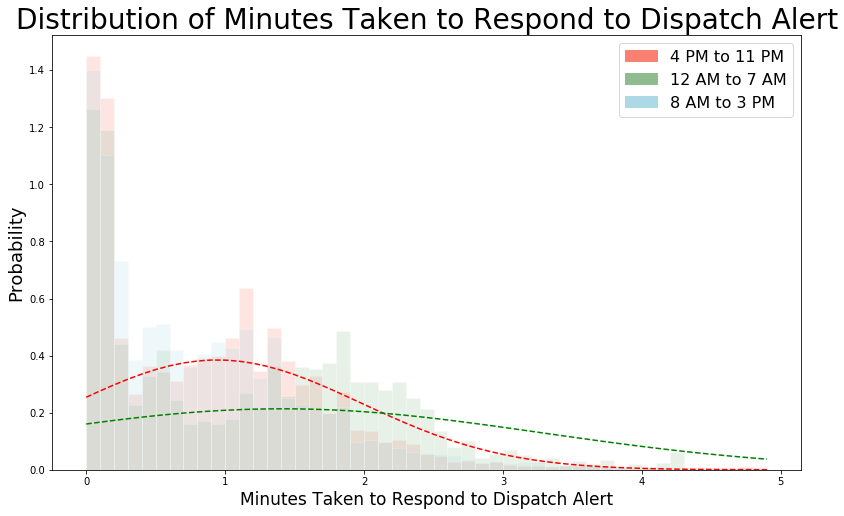

In [71]:
# All three - might be difficult to distinguish between them
x = dfc[dfc['day_portion'] == '4 PM to 11 PM']['dispatch_to_response'].dropna()
x2 = dfc[dfc['day_portion'] == '12 AM to 7 AM']['dispatch_to_response'].dropna()
x3 = dfc[dfc['day_portion'] == '8 AM to 3 PM']['dispatch_to_response'].dropna()

bins = np.arange(0, 5, .1)
plt.figure(figsize=(13,8))
n, bins, patches = plt.hist(x.dropna(), bins, normed=1, facecolor='salmon', alpha=0.2, 
                            label='4 PM to 11 PM', edgecolor=(1,1,1))
n, bins, patches = plt.hist(x2.dropna(), bins, normed=1, facecolor='darkseagreen', alpha=0.2, 
                            label='12 AM to 7 AM', edgecolor=(1,1,1))
n, bins, patches = plt.hist(x3.dropna(), bins, normed=1, facecolor='lightblue', alpha=0.2, 
                            label='12 AM to 7 AM', edgecolor=(1,1,1))

# mean and standard deviation calc's
mu, sigma = np.mean(x), np.std(x)
mu2, sigma2 = np.mean(x2), np.std(x2)
mu3, sigma3 = np.mean(x3), np.std(x3)

# fit and overlay a 'best fit' line by approximating normal distribution
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
y2 = mlab.normpdf(bins, mu2, sigma2)
plt.plot(bins, y2, 'g--')
# y3 = mlab.normpdf(bins, mu3, sigma3)
# plt.plot(bins, y3, 'b--')

plt.xlabel('Minutes Taken to Respond to Dispatch Alert', fontsize=17)
plt.ylabel('Probability', fontsize=18)
plt.title('Distribution of Minutes Taken to Respond to Dispatch Alert', fontsize=28)

red_patch = mpatches.Patch(color='salmon', label='4 PM to 11 PM')
green_patch = mpatches.Patch(color='darkseagreen', label='12 AM to 7 AM')
blue = mpatches.Patch(color='lightblue', label='8 AM to 3 PM')
plt.legend(handles=[red_patch, green_patch, blue], prop={'size': 16})

# tweak spacing to prevent clipping of ylabel and set axis ranges to include all values
plt.subplots_adjust(left=0.1)
#pylab.ylim([0,y.max()])
# pylab.xlim([x.min(),x.max()])
plt.show()

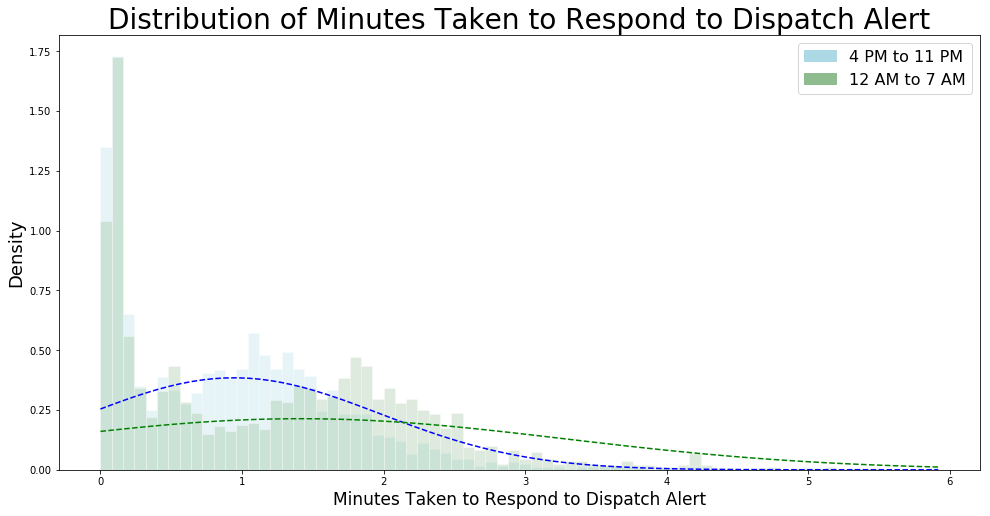

In [72]:
# Let's try just two that seem to have the most difference- late night and late evening, with new colors
x = dfc[dfc['day_portion'] == '4 PM to 11 PM']['dispatch_to_response'].dropna()
x2 = dfc[dfc['day_portion'] == '12 AM to 7 AM']['dispatch_to_response'].dropna()
bins = np.arange(0, 6, .08)
plt.figure(figsize=(16,8))

n, bins, patches = plt.hist(x.dropna(), bins, density = True, color='lightblue', alpha=0.3, 
                            label='4 PM to 11 PM', edgecolor=(1,1,1))
n, bins, patches = plt.hist(x2.dropna(), bins, density = True, color='darkseagreen', alpha=0.3, 
                            label='12 AM to 7 AM', edgecolor=(1,1,1))

# mean and standard deviation calc's
mu, sigma = np.mean(x), np.std(x)
mu2, sigma2 = np.mean(x2), np.std(x2)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'b--')
y2 = mlab.normpdf(bins, mu2, sigma2)
plt.plot(bins, y2, 'g--')
plt.xlabel('Minutes Taken to Respond to Dispatch Alert', fontsize=17)
plt.ylabel('Density', fontsize=18)
plt.title('Distribution of Minutes Taken to Respond to Dispatch Alert', fontsize=28)

lightblue = mpatches.Patch(color='lightblue', label='4 PM to 11 PM')
green_patch = mpatches.Patch(color='darkseagreen', label='12 AM to 7 AM')
plt.legend(handles=[lightblue, green_patch], prop={'size': 16})

# tweak spacing to prevent clipping of ylabel and set axis ranges to include all values
plt.subplots_adjust(left=0.1)
#pylab.ylim([0,y.max()])
# pylab.xlim([x.min(),x.max()])
plt.savefig('time_dist.png')
plt.show()

Police are quickest during late evening hours (4 PM - 11 PM), in the middle in the early morning to late afternoon (8 AM to 3 PM), and slowest at late night hours from 12 AM and 7 AM.

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 <a list of 10 Text yticklabel objects>)

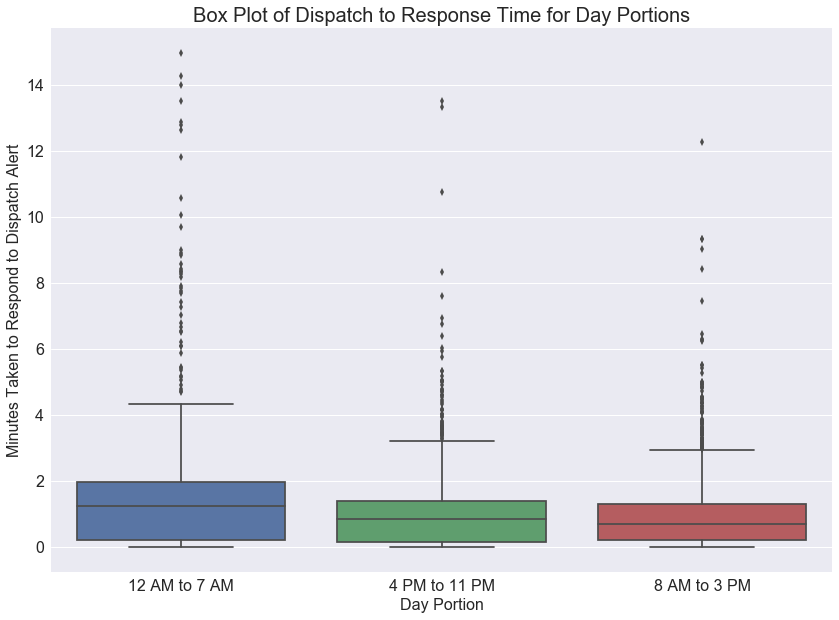

In [115]:
# Distributions by day portion for response time with box and whisker plots
temp = dfc.sort_values('dispatch_to_response', ascending = False)
temp = temp.iloc[10:] # drop extreme outliers (hurts to do, but boxplot is invisible with them!)

sns.set(rc={'figure.figsize':(14,10)})
sns.boxplot(x="day_portion", y="dispatch_to_response", data=temp)
plt.title('Box Plot of Dispatch to Response Time for Day Portions', fontsize = 20)
plt.xlabel('Day Portion', fontsize = 16)
plt.ylabel('Minutes Taken to Respond to Dispatch Alert', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.savefig('assets/box.png')

In [74]:
# Which hour are emergency responders the slowest to reach on scene?
get_group_averages(dfc, 'hour', 'received_to_onscene')

[(22, 17.06626126126126),
 (21, 14.243143459915613),
 (4, 10.53978494623656),
 (9, 10.49038142620232),
 (8, 10.154180985108821),
 (18, 10.087741686001548),
 (13, 9.843734939759038),
 (0, 9.757581967213115),
 (15, 9.757049891540131),
 (14, 9.72205067300079),
 (6, 9.692028985507246),
 (3, 9.66120857699805),
 (16, 9.652261123267687),
 (19, 9.507871396895787),
 (2, 9.49544817927171),
 (10, 9.433169533169533),
 (17, 9.431958333333334),
 (7, 9.312741046831956),
 (5, 9.105870020964362),
 (12, 8.987113402061855),
 (11, 8.511014851485148),
 (23, 8.443844367015098),
 (20, 8.236340852130326),
 (1, 8.209474412171508)]

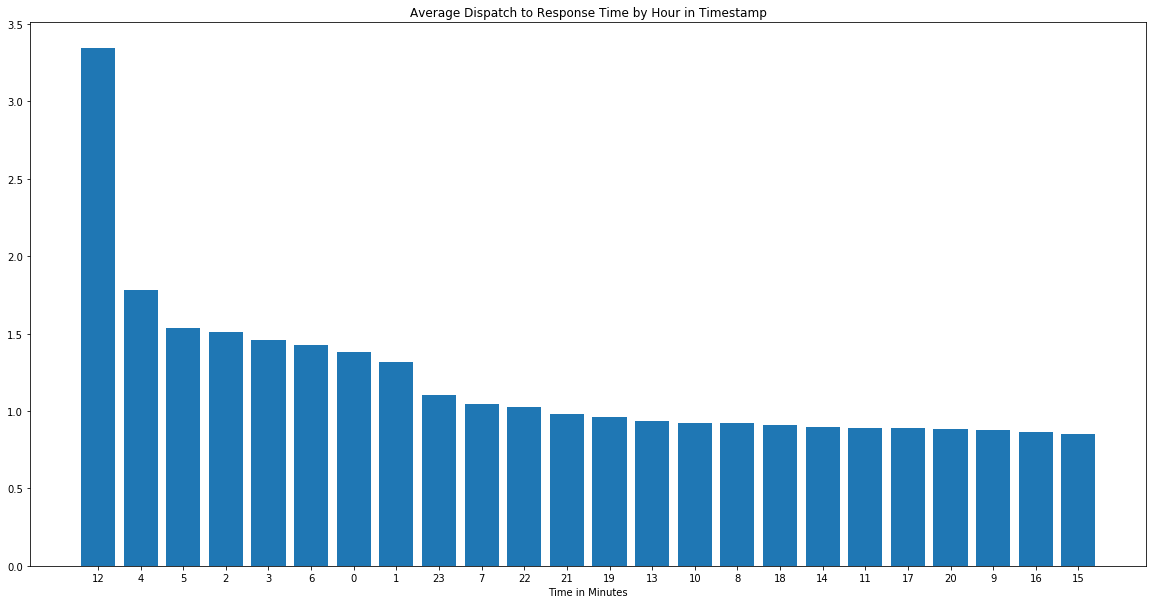

In [75]:
get_sorted_bar(get_group_averages(dfc, 'hour', 'dispatch_to_response'), 'Average Dispatch to Response Time by Hour in Timestamp')

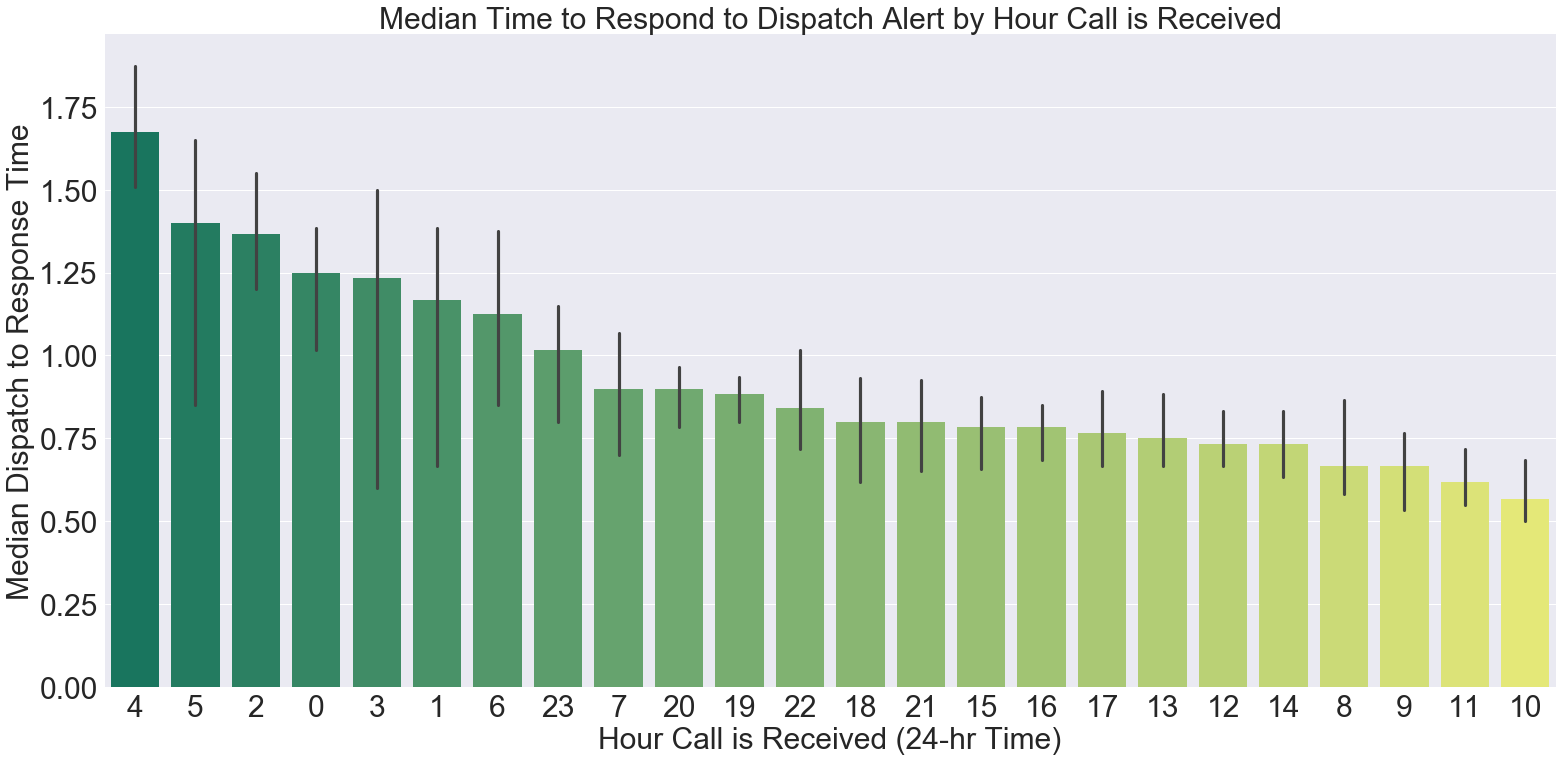

In [282]:
# Plot median response time for each zipcode nicely
zips = get_group_median(dfc, 'hour', 'dispatch_to_response')
X = [x[0] for x in zips]

sns.set(rc={'figure.figsize':(26,12)})
ax = sns.barplot(x="hour", y="dispatch_to_response", data=dfc, estimator=median, palette="summer", 
                order = X)
plt.title('Median Time to Respond to Dispatch Alert by Hour Call is Received', fontsize = 30)
plt.xlabel('Hour Call is Received (24-hr Time)', fontsize = 30)
plt.ylabel('Median Dispatch to Response Time', fontsize = 30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.savefig('assets/hour_response.png')

(array([320.,   6.,   9.,  11.,  11.,  27.,  23.,  22.,  33.,  39.,  49.,
         71.,  67.,  83.,  62., 105., 134.,  94., 149., 119., 135., 167.,
        172., 161., 121., 162., 177., 184., 132., 115., 140., 130., 158.,
        102., 112., 116., 127., 136., 101.,  68., 101.,  80.,  83.,  97.,
         87., 100.,  64.,  92.,  71.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
 <a list of 49 Patch objects>)

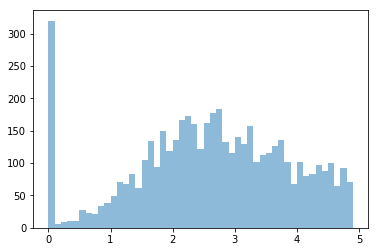

In [76]:
# Quick check of distribution
plt.hist(dfc['response_to_onscene'].dropna(), alpha = .5, bins = np.arange(0, 5, .1), label='dispatch_to_response')

In [77]:
get_group_averages(dfc, 'day_portion', 'response_to_onscene')

[('8 AM to 3 PM', 5.912497463988639),
 ('4 PM to 11 PM', 5.772066859530698),
 ('12 AM to 7 AM', 5.263813191153239)]

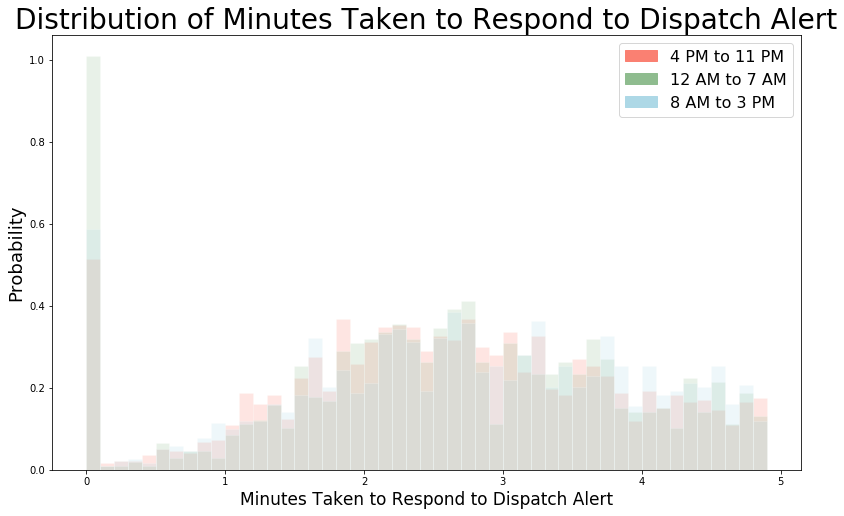

In [90]:
# Plot all three distributions to check for trends
x = dfc[dfc['day_portion'] == '4 PM to 11 PM']['response_to_onscene'].dropna()
x2 = dfc[dfc['day_portion'] == '12 AM to 7 AM']['response_to_onscene'].dropna()
x3 = dfc[dfc['day_portion'] == '8 AM to 3 PM']['response_to_onscene'].dropna()

bins = np.arange(0, 5, .1)
plt.figure(figsize=(13,8))
n, bins, patches = plt.hist(x.dropna(), bins, normed=1, facecolor='salmon', alpha=0.2, 
                            label='4 PM to 11 PM', edgecolor=(1,1,1))
n, bins, patches = plt.hist(x2.dropna(), bins, normed=1, facecolor='darkseagreen', alpha=0.2, 
                            label='12 AM to 7 AM', edgecolor=(1,1,1))
n, bins, patches = plt.hist(x3.dropna(), bins, normed=1, facecolor='lightblue', alpha=0.2, 
                            label='12 AM to 7 AM', edgecolor=(1,1,1))

# mean and standard deviation calc's
mu, sigma = np.mean(x), np.std(x)
mu2, sigma2 = np.mean(x2), np.std(x2)
mu3, sigma3 = np.mean(x3), np.std(x3)




plt.xlabel('Minutes Taken to Respond to Dispatch Alert', fontsize=17)
plt.ylabel('Probability', fontsize=18)
plt.title('Distribution of Minutes Taken to Respond to Dispatch Alert', fontsize=28)


red_patch = mpatches.Patch(color='salmon', label='4 PM to 11 PM')
green_patch = mpatches.Patch(color='darkseagreen', label='12 AM to 7 AM')
blue = mpatches.Patch(color='lightblue', label='8 AM to 3 PM')
plt.legend(handles=[red_patch, green_patch, blue], prop={'size': 16})

# tweak spacing to prevent clipping of ylabel and set axis ranges to include all values
plt.subplots_adjust(left=0.1)
#pylab.ylim([0,y.max()])
# pylab.xlim([x.min(),x.max()])
plt.show()

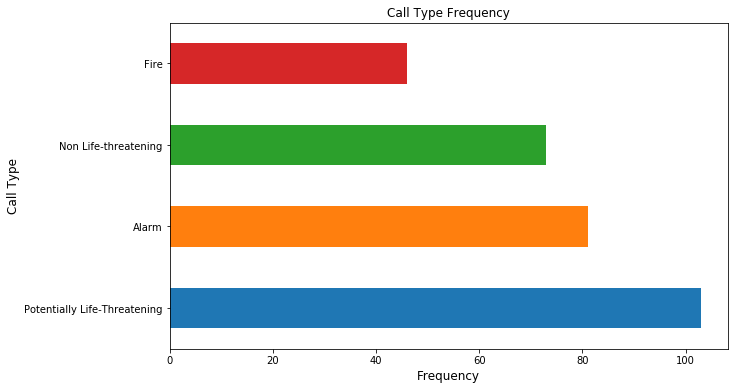

In [109]:
def value_count(df):
    df['call_type_group'].value_counts()[:20].plot(kind='barh', figsize=[10,6])
    plt.xlabel('Frequency', fontsize = 12)
    plt.title('Call Type Frequency')
    plt.ylabel('Call Type', fontsize = 12)
    
value_count(dfc[dfc.zipcode_of_incident == 94105])

In [91]:
# Let's use some outside data!
# These are python dictionaries generated by the script scrape_incomes.py
# They provide median income and population measurements for each zipcode in San Francisco

income_dict = {94127: 95313, 94105: 88976, 94123: 84710, 94130: 80959, 94131: 76044, 94114: 75727, 94129: 73571, 94116: 66627, 94117: 63983, 94121: 61776, 94118: 61609, 94107: 61362, 94122: 60733, 94112: 57629, 94111: 56569, 94132: 55000, 94115: 54879, 94134: 54342, 94110: 53795, 94109: 43444, 94133: 40990, 94124: 37146, 94108: 31542, 94103: 31131, 94102: 22351, 94104: 14609}
population_dict = {94127: 20624, 94105: 2058, 94123: 22903, 94130: 1453, 94131: 27897, 94114: 30574, 94129: 2228, 94116: 42958, 94117: 38738, 94121: 42473, 94118: 38939, 94107: 17368, 94122: 55492, 94112: 73104, 94111: 3335, 94132: 26291, 94115: 33115, 94134: 40134, 94110: 74633, 94109: 56322, 94133: 26827, 94124: 33170, 94108: 13716, 94103: 23016, 94102: 28991, 94104: 374}

In [93]:
# Function to read values from dictionary and put into right place in our dataframe
def read_dict(d, x):
    if x in d:
        return d[x]
    return np.nan

# Create income and population columns
dfc['avg_income'] = dfc['zipcode_of_incident'].apply(lambda x: read_dict(income_dict, x))
dfc['population'] = dfc['zipcode_of_incident'].apply(lambda x: read_dict(population_dict, x))
dfc.head()

,call_number,unit_id,incident_number,call_type,call_date,watch_date,received_timestamp,entry_timestamp,dispatch_timestamp,response_timestamp,...,longitude,received_to_dispatch,received_to_onscene,hour,day,day_portion,dispatch_to_response,response_to_onscene,avg_income,population
0,180243072,84,18010216,Medical Incident,2018-01-24,2018-01-24,2018-01-24 17:36:16,2018-01-24 17:38:21,2018-01-24 17:39:41,2018-01-24 17:39:45,...,-122.504679,3.416667,17.433333,17,Wednesday,4 PM to 11 PM,0.066667,13.950000,61776.0,42473.0
1,180240538,61,18010011,Medical Incident,2018-01-24,2018-01-23,2018-01-24 07:05:05,2018-01-24 07:05:05,2018-01-24 07:05:31,2018-01-24 07:05:45,...,-122.420001,0.433333,13.950000,7,Wednesday,12 AM to 7 AM,0.233333,13.283333,31131.0,23016.0
2,180240176,E22,18009959,Medical Incident,2018-01-24,2018-01-23,2018-01-24 02:04:21,2018-01-24 02:05:37,2018-01-24 02:06:04,2018-01-24 02:07:26,...,-122.475540,1.716667,5.683333,2,Wednesday,12 AM to 7 AM,1.366667,2.600000,60733.0,55492.0
3,180243588,E03,18010271,Alarms,2018-01-24,2018-01-24,2018-01-24 20:04:15,2018-01-24 20:05:12,2018-01-24 20:05:24,2018-01-24 20:05:36,...,-122.423163,1.150000,4.033333,20,Wednesday,4 PM to 11 PM,0.200000,2.683333,43444.0,56322.0
4,180243590,B03,18010272,Alarms,2018-01-24,2018-01-24,2018-01-24 20:03:08,2018-01-24 20:05:36,2018-01-24 20:05:57,2018-01-24 20:06:56,...,-122.393089,2.816667,6.116667,20,Wednesday,4 PM to 11 PM,0.983333,2.316667,61362.0,17368.0


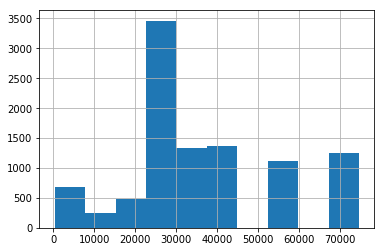

In [84]:
# Quick check of distribution
dfc['population'].hist()

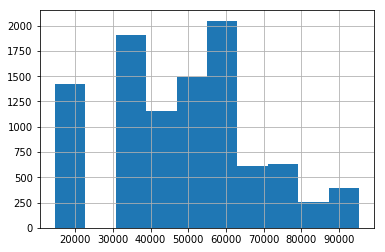

In [94]:
dfc['avg_income'].hist()

In [85]:
dfc['avg_income'].describe()

count     9912.000000
mean     49412.250504
std      18707.184179
min      14609.000000
25%      31131.000000
50%      53795.000000
75%      61362.000000
max      95313.000000
Name: avg_income, dtype: float64

In [95]:
# Assign lower, lower-middle, upper-middle, upper to income quartiles categorical variable for analysis by group
def assign_income_band(x): 
    if x <= 25000:
        return '0 - 25,000'
    if x <= 50000:
        return '25,000 - 50,000'
    if x <= 75000:
        return '50,000 - 75,000'
    return '75,000 - 100,000'
    
dfc['zip_income_band'] = dfc['avg_income'].apply(assign_income_band)
dfc.head()

,call_number,unit_id,incident_number,call_type,call_date,watch_date,received_timestamp,entry_timestamp,dispatch_timestamp,response_timestamp,...,received_to_dispatch,received_to_onscene,hour,day,day_portion,dispatch_to_response,response_to_onscene,avg_income,population,zip_income_band
0,180243072,84,18010216,Medical Incident,2018-01-24,2018-01-24,2018-01-24 17:36:16,2018-01-24 17:38:21,2018-01-24 17:39:41,2018-01-24 17:39:45,...,3.416667,17.433333,17,Wednesday,4 PM to 11 PM,0.066667,13.950000,61776.0,42473.0,"50,000 - 75,000"
1,180240538,61,18010011,Medical Incident,2018-01-24,2018-01-23,2018-01-24 07:05:05,2018-01-24 07:05:05,2018-01-24 07:05:31,2018-01-24 07:05:45,...,0.433333,13.950000,7,Wednesday,12 AM to 7 AM,0.233333,13.283333,31131.0,23016.0,"25,000 - 50,000"
2,180240176,E22,18009959,Medical Incident,2018-01-24,2018-01-23,2018-01-24 02:04:21,2018-01-24 02:05:37,2018-01-24 02:06:04,2018-01-24 02:07:26,...,1.716667,5.683333,2,Wednesday,12 AM to 7 AM,1.366667,2.600000,60733.0,55492.0,"50,000 - 75,000"
3,180243588,E03,18010271,Alarms,2018-01-24,2018-01-24,2018-01-24 20:04:15,2018-01-24 20:05:12,2018-01-24 20:05:24,2018-01-24 20:05:36,...,1.150000,4.033333,20,Wednesday,4 PM to 11 PM,0.200000,2.683333,43444.0,56322.0,"25,000 - 50,000"
4,180243590,B03,18010272,Alarms,2018-01-24,2018-01-24,2018-01-24 20:03:08,2018-01-24 20:05:36,2018-01-24 20:05:57,2018-01-24 20:06:56,...,2.816667,6.116667,20,Wednesday,4 PM to 11 PM,0.983333,2.316667,61362.0,17368.0,"50,000 - 75,000"


In [87]:
# Check frequency proportion by income band
dfc['zip_income_band'].value_counts(normalize = True)
# Middle class seems to have most emergencies, *but* as seen in the distribution above, they're also the most common

Upper-Middle    0.4199
Lower-Middle    0.3062
Lower           0.1422
Upper           0.1317
Name: zip_income_band, dtype: float64

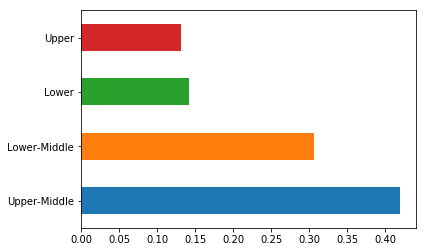

In [88]:
# Barplot of income band frequency proportions
dfc['zip_income_band'].value_counts(normalize = True).plot(kind = 'barh')

In [97]:
# Check means and medians
print (get_group_averages(dfc, 'zip_income_band', 'received_to_onscene'))
print (get_group_median(dfc, 'zip_income_band', 'received_to_onscene'))

[('75,000 - 100,000', 14.012934362934363), ('50,000 - 75,000', 9.554409196740394), ('25,000 - 50,000', 9.31676714898178), ('0 - 25,000', 9.104370370370372)]
[('75,000 - 100,000', 7.666666666666667), ('50,000 - 75,000', 7.483333333333333), ('25,000 - 50,000', 7.308333333333334), ('0 - 25,000', 7.05)]


## Given an address and time, can we predict the most likely dispatch that will be required?

Yes, if we roughly equate emergency frequencies in January to likelihood.  
Let's write an algorithm that goes through our DataFrame and pulls the proportional frequency for various call types (Medical incident, fire, etc.) for a given set of parameters, namely a zipcode or station area and a time of day or portion of day. If we get too specific, it will be hard to find enough instances to generalize, so we can keep it to these two parameters for now. For example, there may only be one emergency that occured on a Wednesday at 3 PM in zipcode 94127, so being too specific won't let us interpret our results as a likelihood.  
The frequency in January is probably only roughly indicative of a likelihood given an address and time, but we do have 10,0000 calls, so it's worth a shot.   
The python dictionary generated from this can be used in Javascript to create a small functional part on our website which outputs the top most frequent (and thereby "likely") emergency types given an zipcode and time input by the user.  

We need to do this without being too specific - zipcode and station areas have enough different values to be useful (box would be impractical because there is too many of them, whereas there's too few battalions). Thus these provide us with a balanced granularity in terms of location. As for time, we can try using both day portions (day divided into 7 hour periods) or hours directly. 

In [193]:
# This is how we can subset the dataframe given a location and time
dfc[(dfc.zipcode_of_incident == 94129) & (dfc.day_portion == '4 PM to 11 PM')].head()

,call_number,unit_id,incident_number,call_type,call_date,watch_date,received_timestamp,entry_timestamp,dispatch_timestamp,response_timestamp,...,received_to_dispatch,received_to_onscene,hour,day,day_portion,dispatch_to_response,response_to_onscene,avg_income,population,zip_income_band
4437,180192988,T16,18008183,Water Rescue,2018-01-19,2018-01-19,2018-01-19 17:31:53,2018-01-19 17:35:31,2018-01-19 17:36:59,2018-01-19 17:38:26,...,5.1,12.083333,17,Friday,4 PM to 11 PM,1.450000,5.533333,73571.0,2228.0,"50,000 - 75,000"
4557,180192988,E34,18008183,Water Rescue,2018-01-19,2018-01-19,2018-01-19 17:31:53,2018-01-19 17:35:31,2018-01-19 17:36:59,2018-01-19 17:38:31,...,5.1,NaN,17,Friday,4 PM to 11 PM,1.533333,NaN,73571.0,2228.0,"50,000 - 75,000"
4697,180192988,RS1,18008183,Water Rescue,2018-01-19,2018-01-19,2018-01-19 17:31:53,2018-01-19 17:35:31,2018-01-19 17:36:59,2018-01-19 17:37:57,...,5.1,NaN,17,Friday,4 PM to 11 PM,0.966667,NaN,73571.0,2228.0,"50,000 - 75,000"
4754,180192988,T14,18008183,Water Rescue,2018-01-19,2018-01-19,2018-01-19 17:31:53,2018-01-19 17:35:31,2018-01-19 17:36:59,2018-01-19 17:38:47,...,5.1,11.100000,17,Friday,4 PM to 11 PM,1.800000,4.200000,73571.0,2228.0,"50,000 - 75,000"
4761,180192988,RC2,18008183,Water Rescue,2018-01-19,2018-01-19,2018-01-19 17:31:53,2018-01-19 17:35:31,2018-01-19 17:36:59,2018-01-19 17:38:39,...,5.1,12.783333,17,Friday,4 PM to 11 PM,1.666667,6.016667,73571.0,2228.0,"50,000 - 75,000"


In [102]:
# This is how we can get frequencies given parameters
dfc[(dfc.zipcode_of_incident == 94124) & (dfc.day_portion == '12 AM to 7 AM')]['call_type'].value_counts(normalize = True)

Medical Incident                   0.571429
Structure Fire                     0.158730
Outside Fire                       0.087302
Alarms                             0.079365
Gas Leak (Natural and LP Gases)    0.039683
Traffic Collision                  0.031746
Vehicle Fire                       0.015873
Citizen Assist / Service Call      0.007937
Other                              0.007937
Name: call_type, dtype: float64

In [93]:
# Most likely dispatches, given an address (zipcode) and a time 
# Filters DataFrame with desired parameters and gets frequency proportions for type of emergency
d = {}
for zipcode in set(dfc['zipcode_of_incident']):
    times = []
    for day_portion in ['8 AM to 3 PM', '4 PM to 11 PM', '12 AM to 7 AM']: 
        value_counts = dfc[(dfc.zipcode_of_incident == zipcode) & (dfc.day_portion == day_portion)]['call_type'].value_counts(normalize = True)
        val1 = '1. ' +value_counts.index[0] + ' - ' + str(round(value_counts[0]*100, 0)) + '%;'
        if len(value_counts) == 1: 
            times.append(val1)
        elif len(value_counts) == 2: 
            val2 =  '2. ' + value_counts.index[1] + ' - ' + str(round(value_counts[1]*100, 0)) + '%;'
            times.append(val1 + '  ' + val2)            
        else:
            val2 =   '2. ' +value_counts.index[1] + ' - ' + str(round(value_counts[1]*100, 0)) + '%;'
            val3 =  '3. ' + value_counts.index[2] + ' - ' + str(round(value_counts[2]*100, 0)) + '%;'
            times.append(val1 + '  ' + val2 + '  ' + val3)
    d[zipcode] = times

print (d)

d
{94102: ['1. Medical Incident - 71.0%;  2. Alarms - 13.0%;  3. Structure Fire - 12.0%;', '1. Medical Incident - 71.0%;  2. Structure Fire - 14.0%;  3. Alarms - 11.0%;', '1. Medical Incident - 68.0%;  2. Structure Fire - 18.0%;  3. Alarms - 8.0%;'], 94103: ['1. Medical Incident - 70.0%;  2. Alarms - 12.0%;  3. Traffic Collision - 9.0%;', '1. Medical Incident - 83.0%;  2. Alarms - 5.0%;  3. Structure Fire - 4.0%;', '1. Medical Incident - 70.0%;  2. Structure Fire - 13.0%;  3. Alarms - 10.0%;'], 94104: ['1. Medical Incident - 71.0%;  2. Gas Leak (Natural and LP Gases) - 11.0%;  3. Alarms - 11.0%;', '1. Structure Fire - 41.0%;  2. Medical Incident - 38.0%;  3. Alarms - 10.0%;', '1. Structure Fire - 72.0%;  2. Medical Incident - 28.0%;'], 94105: ['1. Medical Incident - 52.0%;  2. Alarms - 23.0%;  3. Train / Rail Incident - 8.0%;', '1. Medical Incident - 47.0%;  2. Alarms - 23.0%;  3. Train / Rail Incident - 18.0%;', '1. Medical Incident - 72.0%;  2. Train / Rail Incident - 16.0%;  3. Alar

In [94]:
# Test for zipcode 94105 at Midnight
print (d[94105][0])

1. Medical Incident - 52.0%;  2. Alarms - 23.0%;  3. Train / Rail Incident - 8.0%;


In [95]:
for x in set(dfc['zip_income_band']): 
    print (x, '\n', dfc[dfc['zip_income_band'] == x]['call_type'].value_counts(normalize = True)[:2])
# Medical Incidents are the most common calls at every income band

Upper-Middle 
 Medical Incident    0.677066
Alarms              0.099309
Name: call_type, dtype: float64
Lower-Middle 
 Medical Incident    0.713259
Alarms              0.100261
Name: call_type, dtype: float64
Lower 
 Medical Incident    0.692686
Structure Fire      0.154008
Name: call_type, dtype: float64
Upper 
 Medical Incident    0.591496
Alarms              0.138952
Name: call_type, dtype: float64


In [99]:
# Frequency proportion for medical incidents by income quartile
dfc[dfc.call_type == 'Medical Incident'].zip_income_band.value_counts(normalize = True)

50,000 - 75,000     0.418642
25,000 - 50,000     0.321602
0 - 25,000          0.145045
75,000 - 100,000    0.114711
Name: zip_income_band, dtype: float64

In [100]:
dfc[dfc.call_type == 'Alarms'].zip_income_band.value_counts(normalize = True)

50,000 - 75,000     0.393025
25,000 - 50,000     0.289350
75,000 - 100,000    0.172479
0 - 25,000          0.145146
Name: zip_income_band, dtype: float64

In [99]:
# Which times of the day have the most emergencies?
dfc['day_portion'].value_counts()

8 AM to 3 PM     4085
4 PM to 11 PM    3843
12 AM to 7 AM    2072
Name: day_portion, dtype: int64

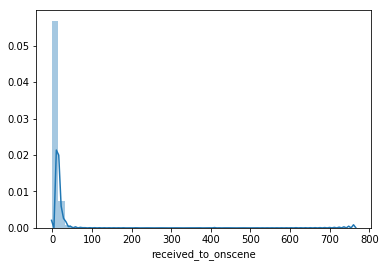

In [104]:
# Distribution of received_to_onscene times- extreme outliers!
ax = sns.distplot(dfc['received_to_onscene'].dropna())

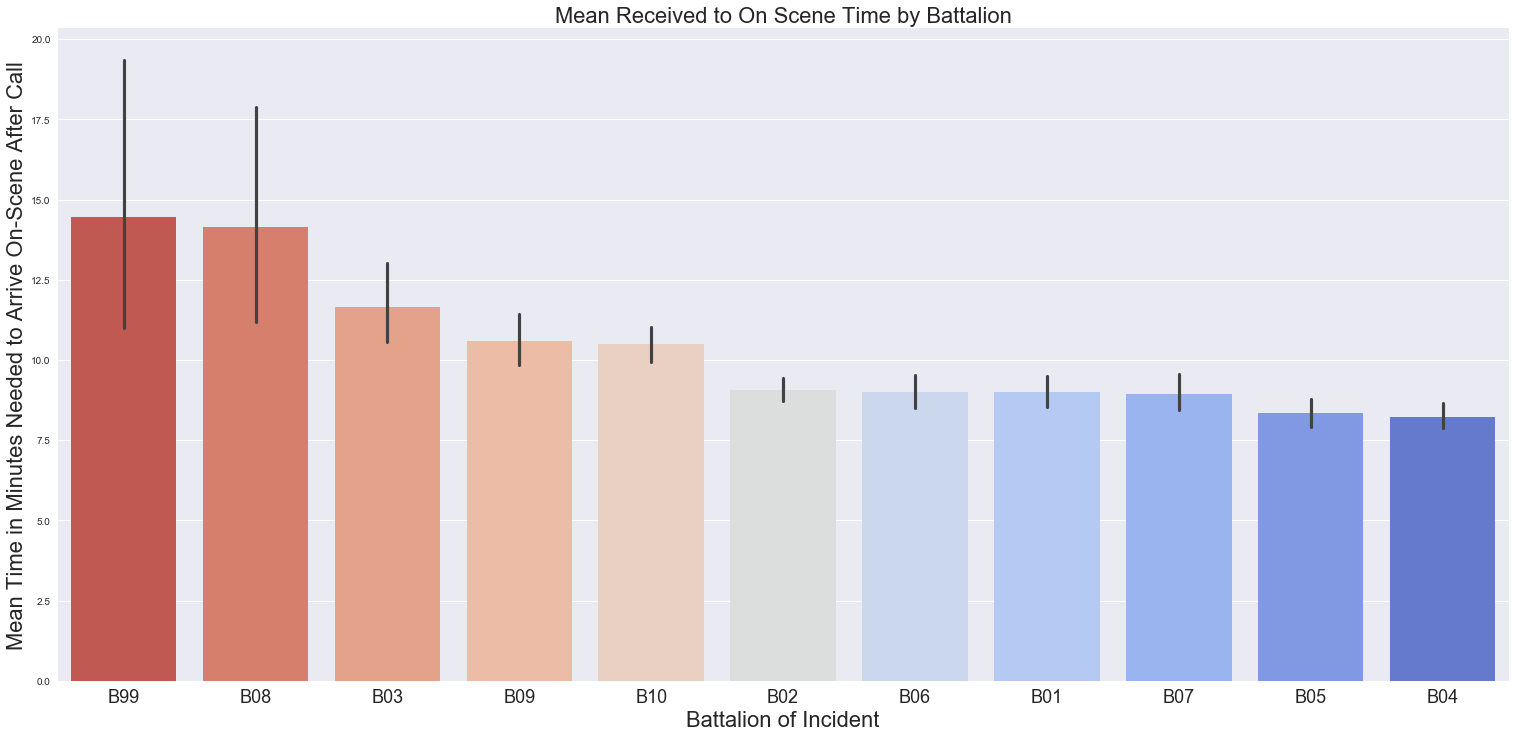

In [453]:
# Barplot response time to each battalion
values = get_group_averages(dfc, 'battalion', 'received_to_onscene')
X = [x[0] for x in values]

sns.set(rc={'figure.figsize':(26,12)})
ax = sns.barplot(x="battalion", y="received_to_onscene", data=dfc, estimator=mean, palette="coolwarm_r", 
                order = X)
plt.title('Mean Received to On Scene Time by Battalion', fontsize = 22)
plt.xlabel('Battalion of Incident', fontsize = 22)
plt.ylabel('Mean Time in Minutes Needed to Arrive On-Scene After Call', fontsize = 22)
plt.xticks(fontsize=18)

#plt.savefig('assets/mean_battalion_response.png')

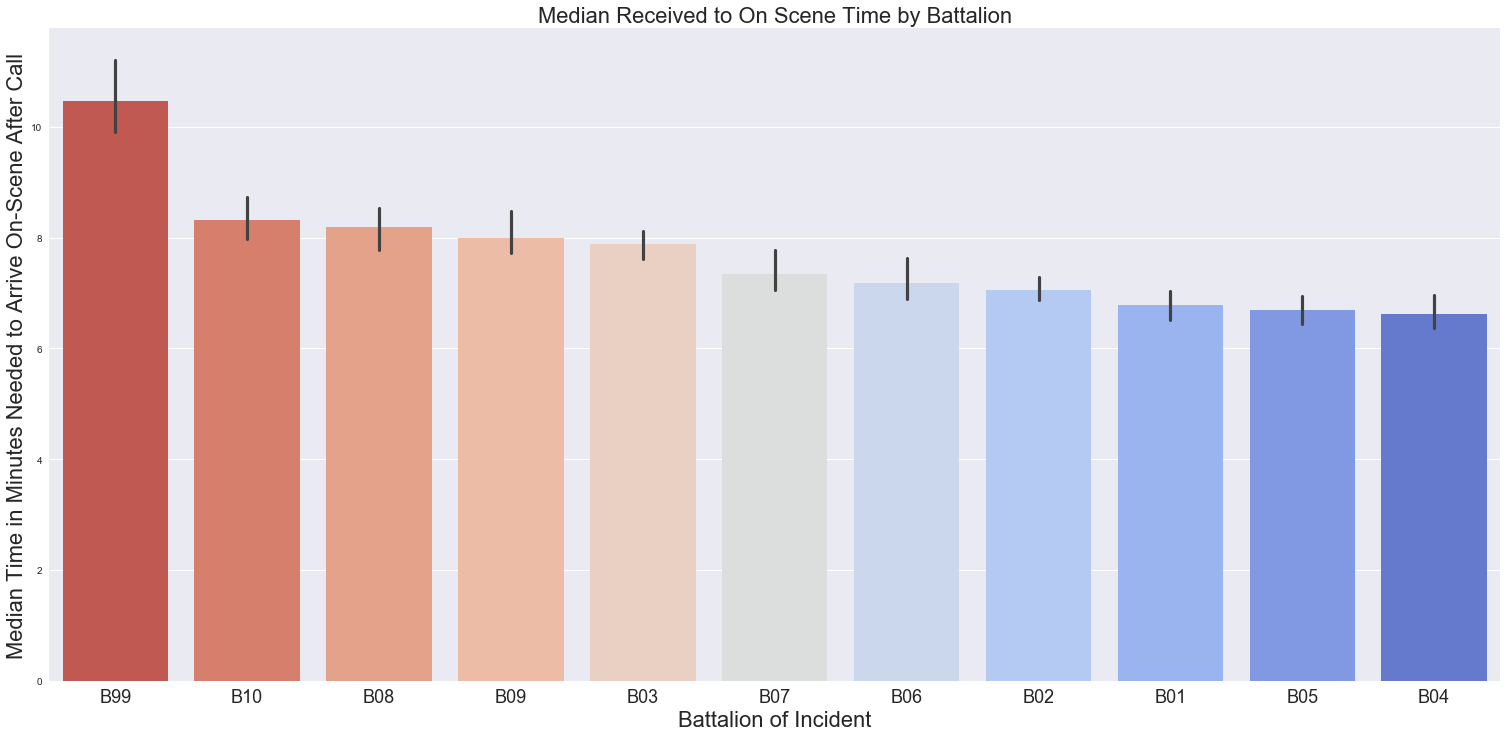

In [454]:
values = get_group_median(dfc, 'battalion', 'received_to_onscene')
X = [x[0] for x in values]

sns.set(rc={'figure.figsize':(26,12)})
ax = sns.barplot(x="battalion", y="received_to_onscene", data=dfc, estimator=median, palette="coolwarm_r", 
                order = X)
plt.title('Median Received to On Scene Time by Battalion', fontsize = 22)
plt.xlabel('Battalion of Incident', fontsize = 22)
plt.ylabel('Median Time in Minutes Needed to Arrive On-Scene After Call', fontsize = 22)
plt.xticks(fontsize=18)

#plt.savefig('assets/median_battalion_response.png')

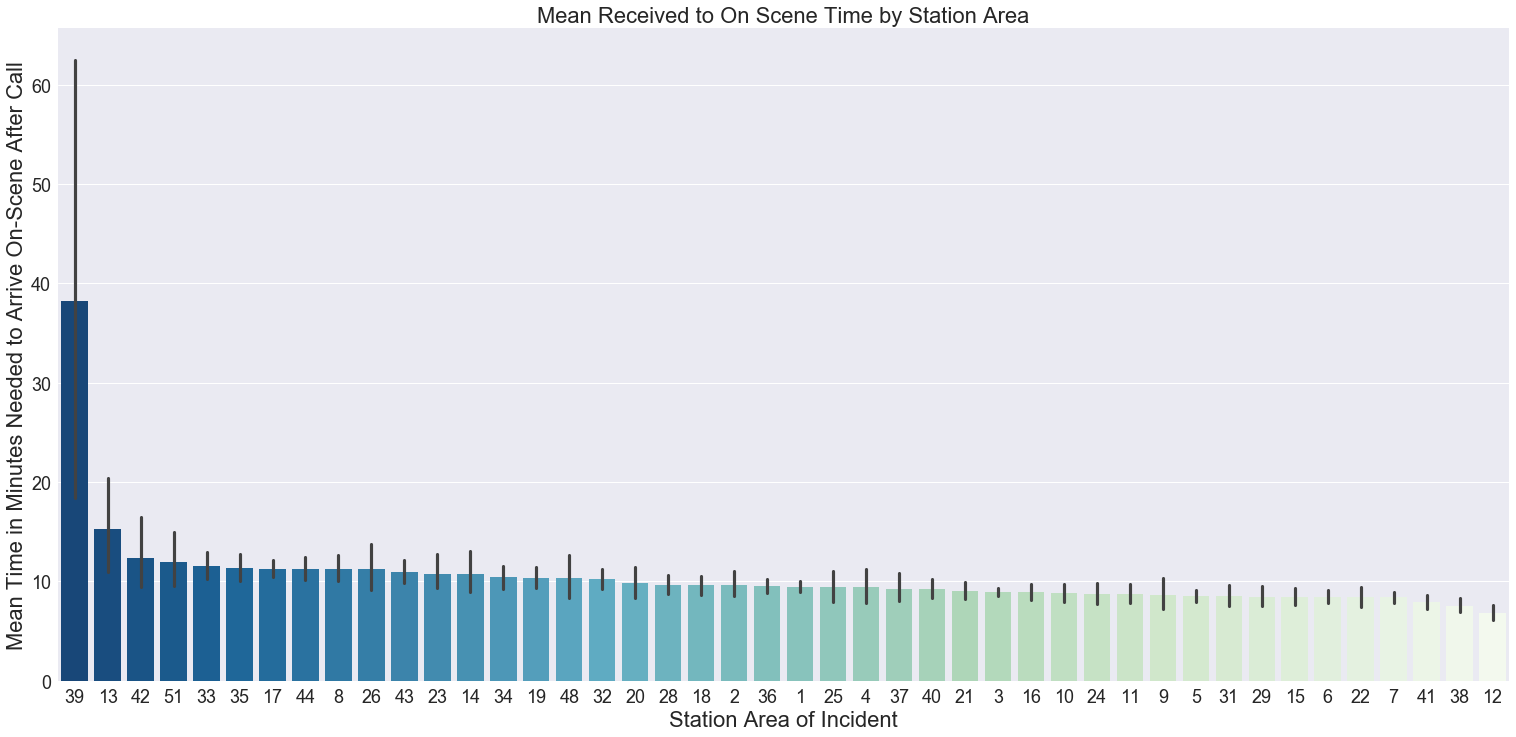

In [455]:
values = get_group_averages(dfc, 'station_area', 'received_to_onscene')
X = [x[0] for x in values]

sns.set(rc={'figure.figsize':(26,12)})
ax = sns.barplot(x="station_area", y="received_to_onscene", data=dfc, estimator=mean, palette="GnBu_r", 
                order = X)
plt.title('Mean Received to On Scene Time by Station Area', fontsize = 22)
plt.xlabel('Station Area of Incident', fontsize = 22)
plt.ylabel('Mean Time in Minutes Needed to Arrive On-Scene After Call', fontsize = 22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.savefig('assets/mean_sa_response.png')

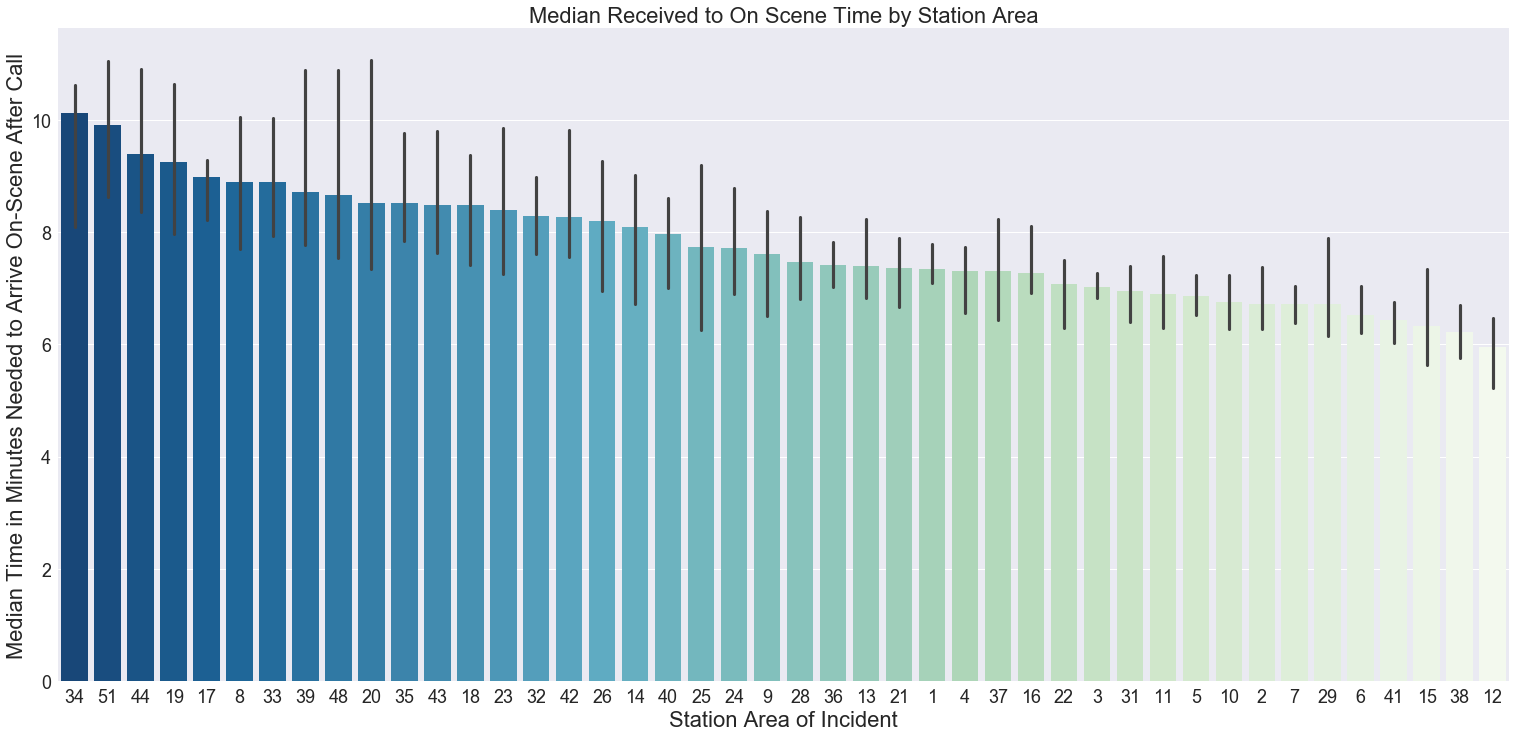

In [456]:
values = get_group_median(dfc, 'station_area', 'received_to_onscene')
X = [x[0] for x in values]

sns.set(rc={'figure.figsize':(26,12)})
ax = sns.barplot(x="station_area", y="received_to_onscene", data=dfc, estimator=median, palette="GnBu_r", 
                order = X)
plt.title('Median Received to On Scene Time by Station Area', fontsize = 22)
plt.xlabel('Station Area of Incident', fontsize = 22)
plt.ylabel('Median Time in Minutes Needed to Arrive On-Scene After Call', fontsize = 22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.savefig('assets/median_sa_response.png')

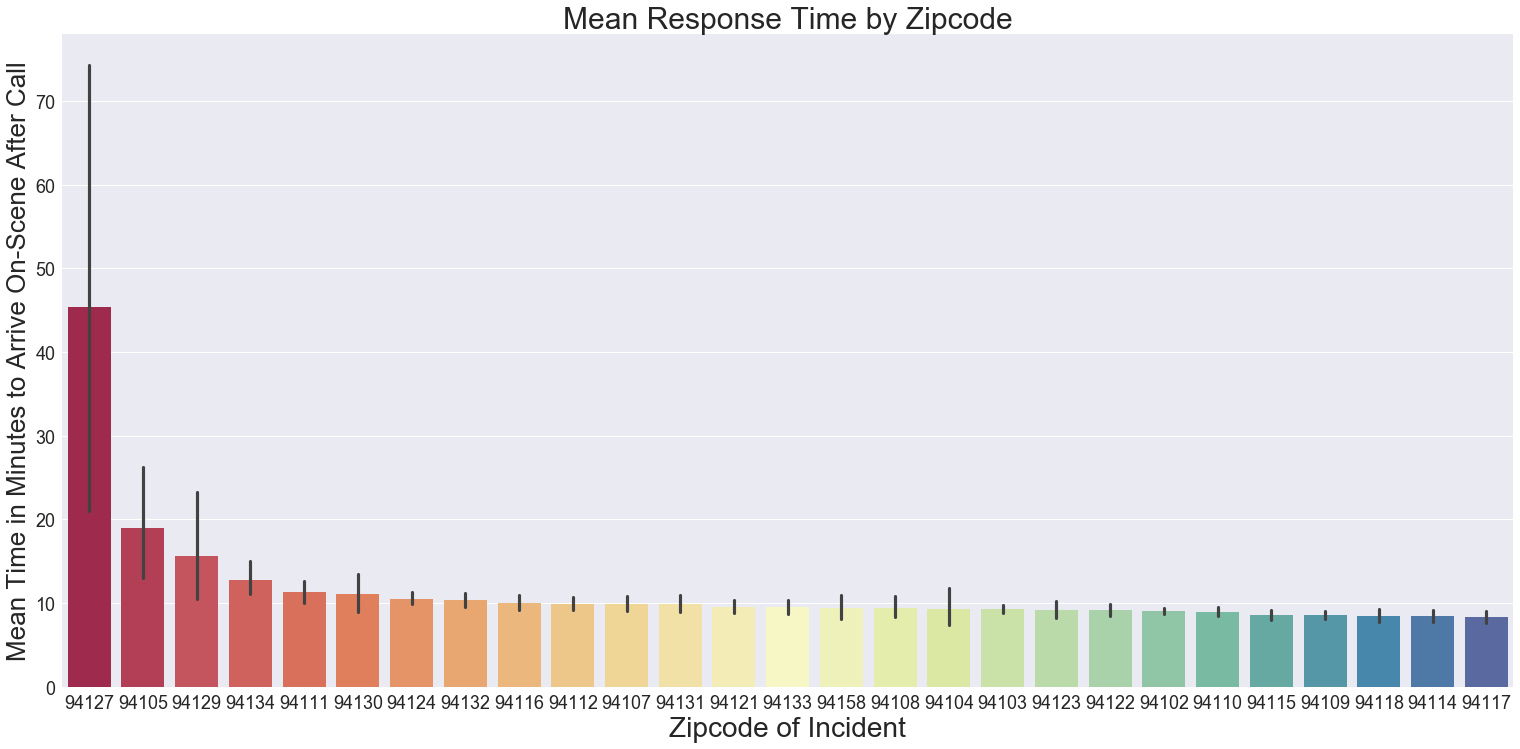

In [457]:
values = get_group_averages(dfc, 'zipcode_of_incident', 'received_to_onscene')
X = [x[0] for x in values]

sns.set(rc={'figure.figsize':(26,12)})
ax = sns.barplot(x="zipcode_of_incident", y="received_to_onscene", data=dfc, estimator=mean, palette="Spectral", 
                order = X)
plt.title('Mean Response Time by Zipcode', fontsize = 30)
plt.xlabel('Zipcode of Incident', fontsize = 28)
plt.ylabel('Mean Time in Minutes to Arrive On-Scene After Call', fontsize = 26)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


#plt.savefig('assets/mean_zipcode_response.png')

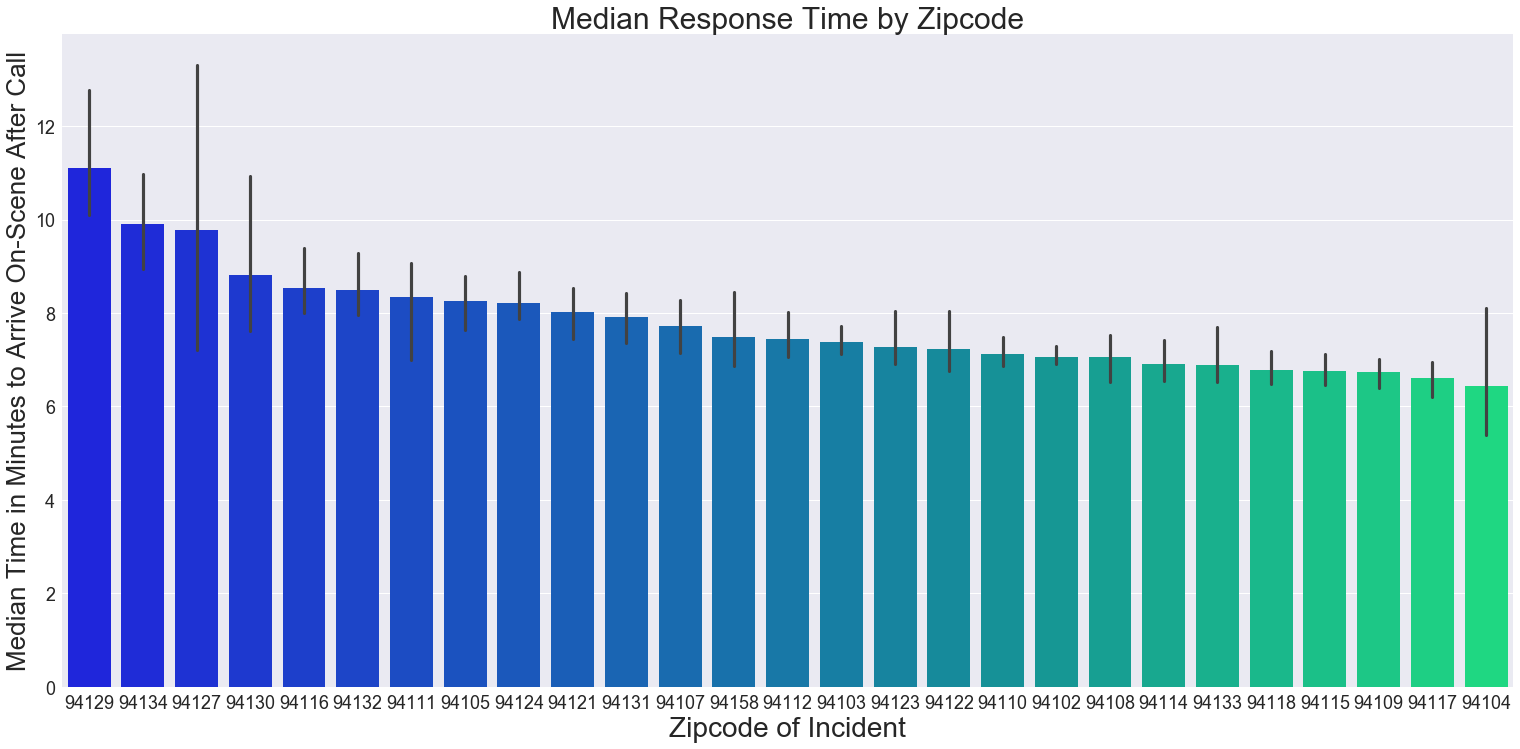

In [458]:
values = get_group_median(dfc, 'zipcode_of_incident', 'received_to_onscene')
X = [x[0] for x in values]

sns.set(rc={'figure.figsize':(26,12)})
ax = sns.barplot(x="zipcode_of_incident", y="received_to_onscene", data=dfc, estimator=median, palette="winter", 
                order = X)
plt.title('Median Response Time by Zipcode', fontsize = 30)
plt.xlabel('Zipcode of Incident', fontsize = 28)
plt.ylabel('Median Time in Minutes to Arrive On-Scene After Call', fontsize = 26)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

#plt.savefig('assets/median_zipcode_response.png')

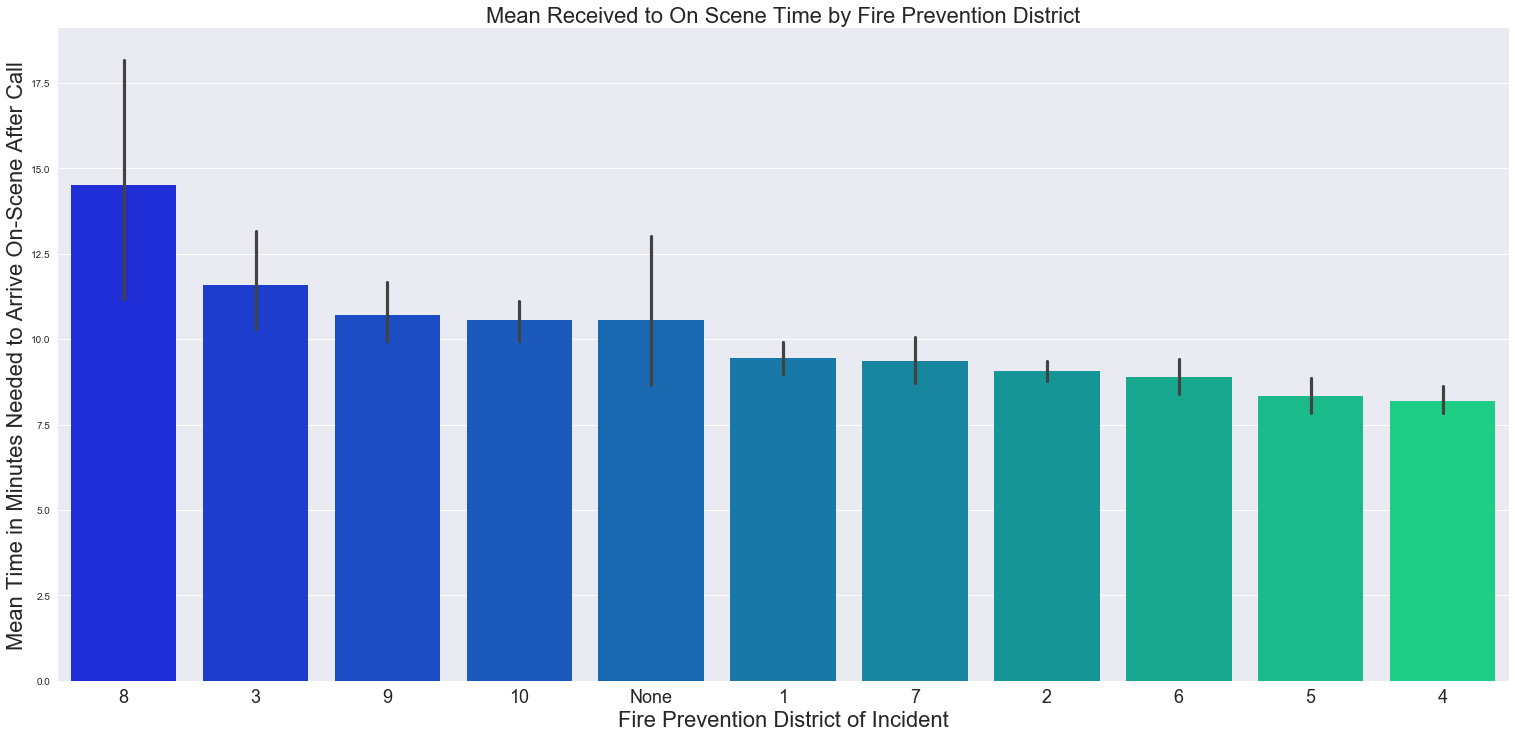

In [459]:
values = get_group_averages(dfc, 'fire_prevention_district', 'received_to_onscene')
X = [x[0] for x in values]

sns.set(rc={'figure.figsize':(26,12)})
ax = sns.barplot(x="fire_prevention_district", y="received_to_onscene", data=dfc, estimator=mean, palette="winter", 
                order = X)
plt.title('Mean Received to On Scene Time by Fire Prevention District', fontsize = 22)
plt.xlabel('Fire Prevention District of Incident', fontsize = 22)
plt.ylabel('Mean Time in Minutes Needed to Arrive On-Scene After Call', fontsize = 22)
plt.xticks(fontsize=18)

#plt.savefig('assets/mean_fpd_response.png')

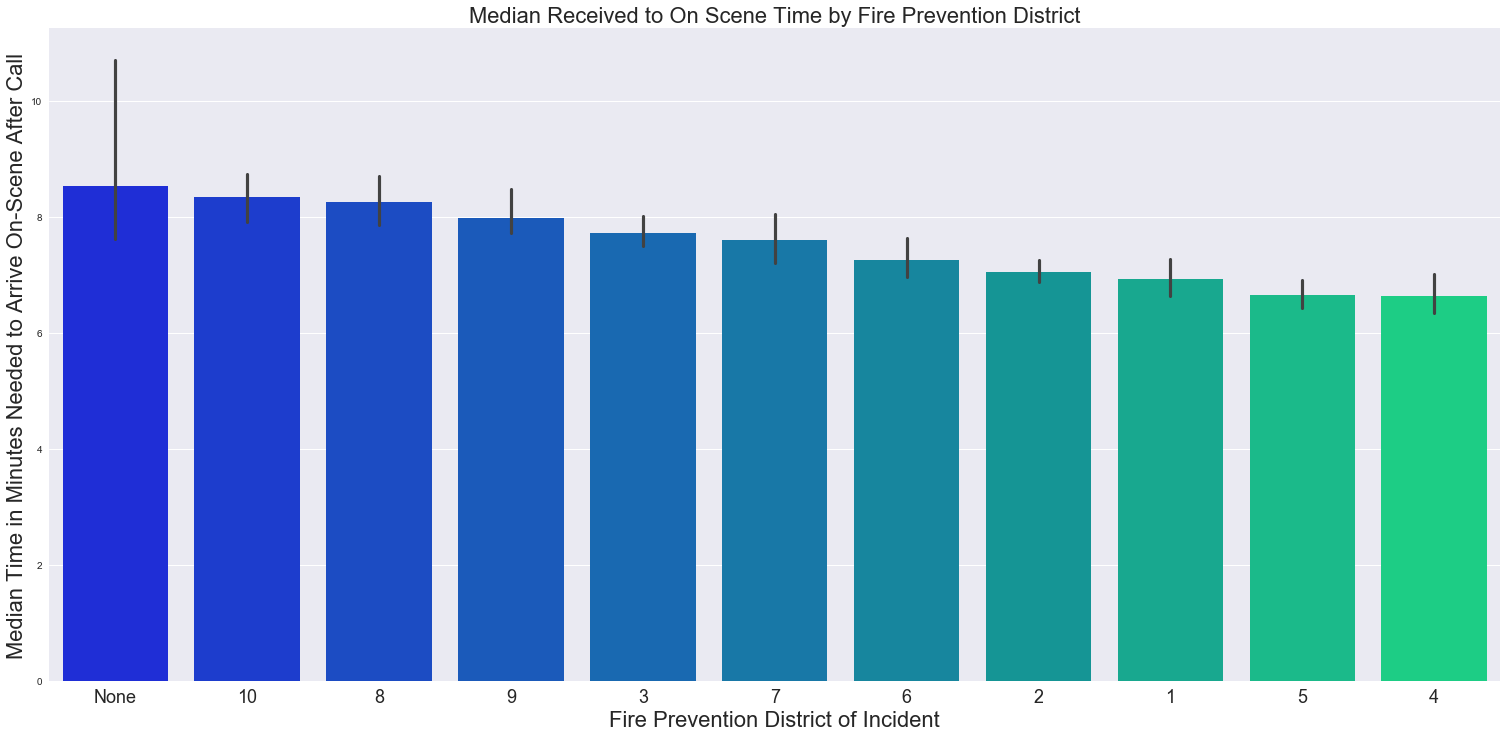

In [460]:
values = get_group_median(dfc, 'fire_prevention_district', 'received_to_onscene')
X = [x[0] for x in values]

sns.set(rc={'figure.figsize':(26,12)})
ax = sns.barplot(x="fire_prevention_district", y="received_to_onscene", data=dfc, estimator=median, palette="winter", 
                order = X)
plt.title('Median Received to On Scene Time by Fire Prevention District', fontsize = 22)
plt.xlabel('Fire Prevention District of Incident', fontsize = 22)
plt.ylabel('Median Time in Minutes Needed to Arrive On-Scene After Call', fontsize = 22)
plt.xticks(fontsize=18)

#plt.savefig('assets/median_fpd_response.png')

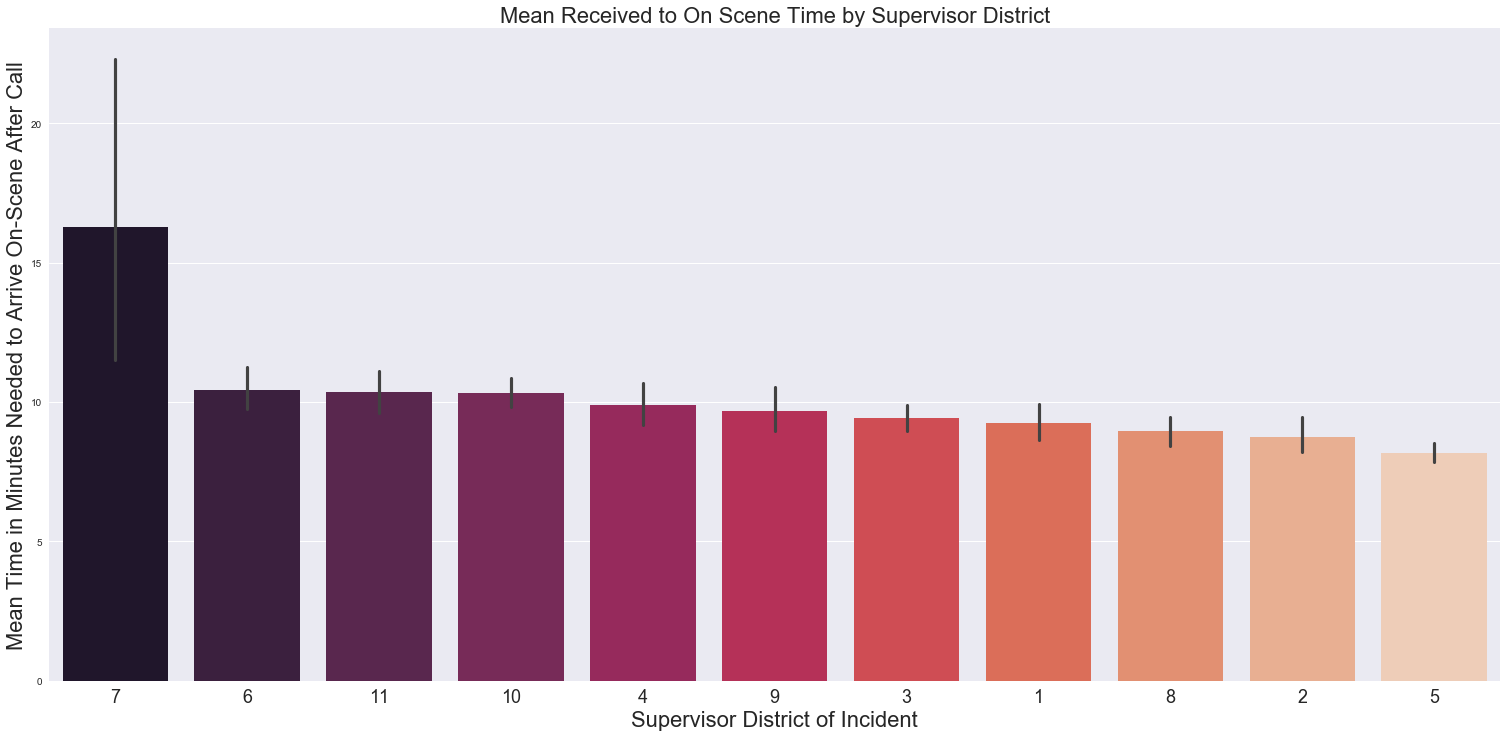

In [461]:
values = get_group_averages(dfc, 'supervisor_district', 'received_to_onscene')
X = [x[0] for x in values]

sns.set(rc={'figure.figsize':(26,12)})
ax = sns.barplot(x="supervisor_district", y="received_to_onscene", data=dfc, estimator=mean, palette="rocket", 
                order = X)
plt.title('Mean Received to On Scene Time by Supervisor District', fontsize = 22)
plt.xlabel('Supervisor District of Incident', fontsize = 22)
plt.ylabel('Mean Time in Minutes Needed to Arrive On-Scene After Call', fontsize = 22)
plt.xticks(fontsize=18)

#plt.savefig('assets/mean_sd_response.png')

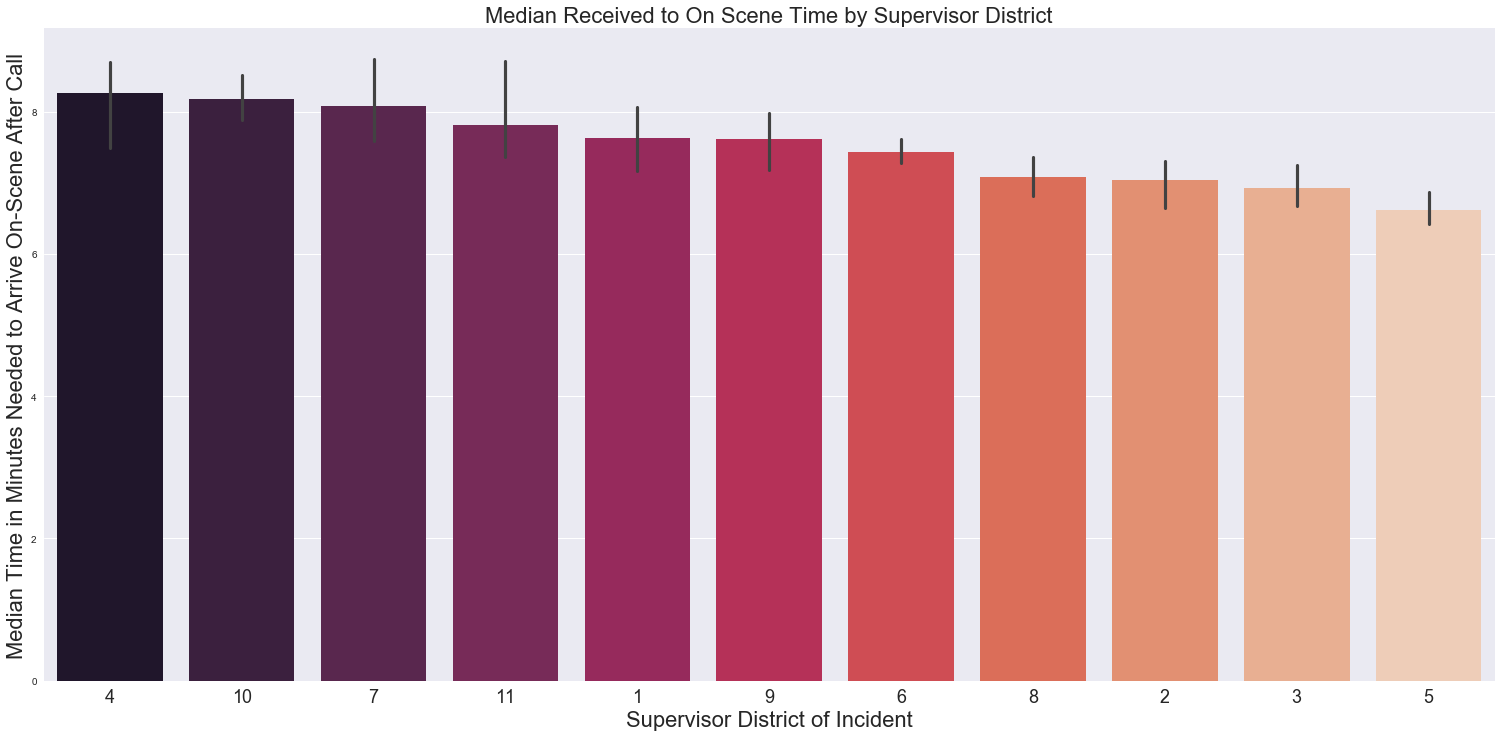

In [462]:
values = get_group_median(dfc, 'supervisor_district', 'received_to_onscene')
X = [x[0] for x in values]

sns.set(rc={'figure.figsize':(26,12)})
ax = sns.barplot(x="supervisor_district", y="received_to_onscene", data=dfc, estimator=median, palette="rocket", 
                order = X)
plt.title('Median Received to On Scene Time by Supervisor District', fontsize = 22)
plt.xlabel('Supervisor District of Incident', fontsize = 22)
plt.ylabel('Median Time in Minutes Needed to Arrive On-Scene After Call', fontsize = 22)
plt.xticks(fontsize=18)

#plt.savefig('assets/median_sd_response.png')

C:\Users\shami\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


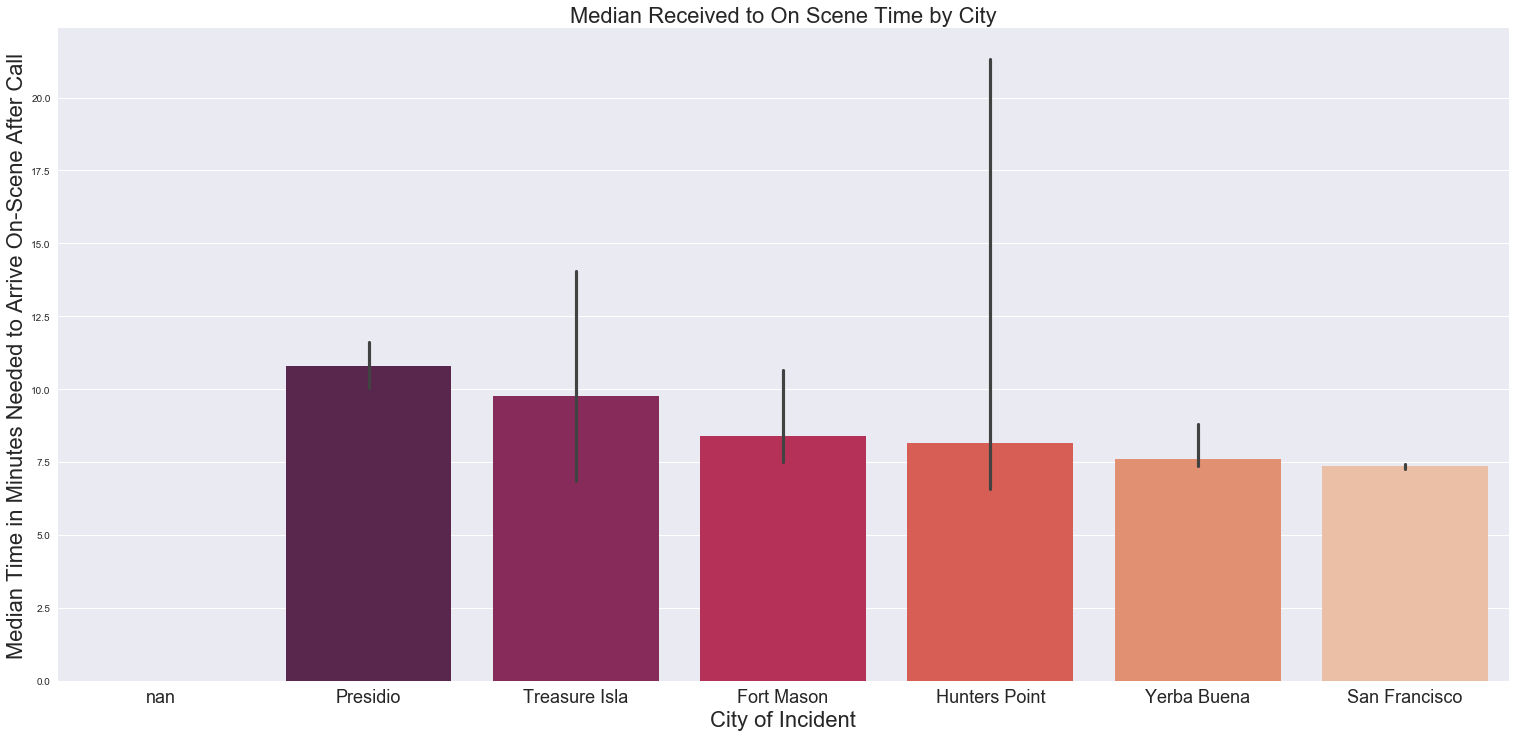

In [465]:
values = get_group_median(dfc, 'city', 'received_to_onscene')
X = [x[0] for x in values]

sns.set(rc={'figure.figsize':(26,12)})
ax = sns.barplot(x="city", y="received_to_onscene", data=dfc, estimator=median, palette="rocket", 
                order = X)
plt.title('Median Received to On Scene Time by City', fontsize = 22)
plt.xlabel('City of Incident', fontsize = 22)
plt.ylabel('Median Time in Minutes Needed to Arrive On-Scene After Call', fontsize = 22)
plt.xticks(fontsize=18)

#plt.savefig('assets/city_response.png')

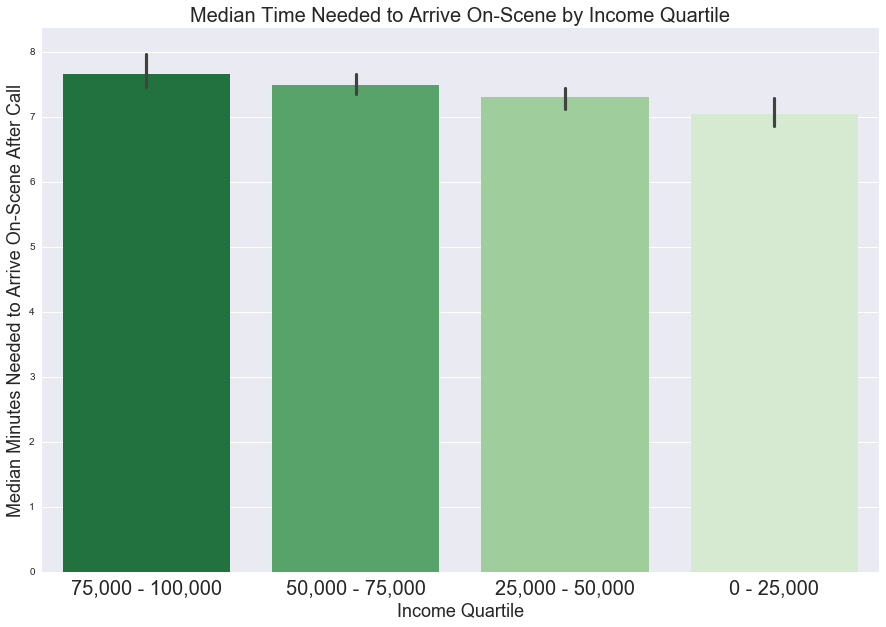

In [302]:
incomes = get_group_averages(dfc, 'zip_income_band', 'received_to_onscene')
X = [x[0] for x in incomes]

sns.set(rc={'figure.figsize':(15,10)})
ax = sns.barplot(x="zip_income_band", y="received_to_onscene", data=dfc, estimator=median, palette="Greens_r", 
                order = X)
plt.title('Median Time Needed to Arrive On-Scene by Income Quartile', fontsize = 20)
plt.xlabel('Income Quartile', fontsize = 18)
plt.ylabel('Median Minutes Needed to Arrive On-Scene After Call', fontsize = 18)
plt.xticks(fontsize=20)
#plt.savefig('assets/incomebands.png')

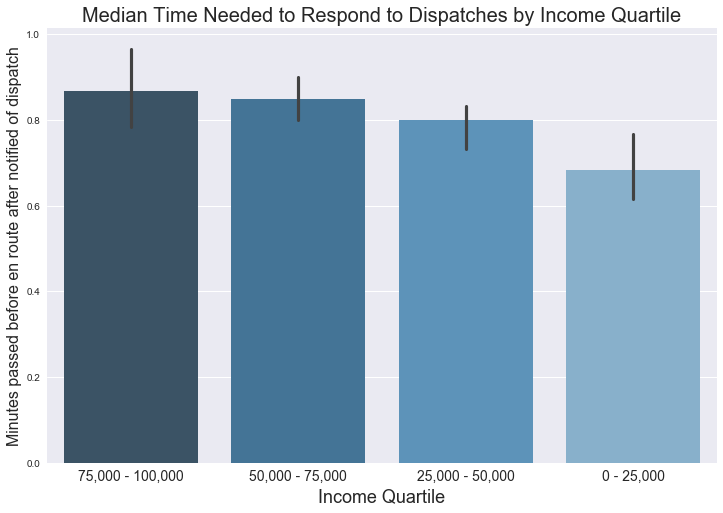

In [304]:
incomes = get_group_median(dfc, 'zip_income_band', 'dispatch_to_response')
X = [x[0] for x in incomes]

sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(x="zip_income_band", y="dispatch_to_response", data=dfc, estimator=median, palette="Blues_d", 
                order = X)
plt.title('Median Time Needed to Respond to Dispatches by Income Quartile', fontsize = 20)
plt.xlabel('Income Quartile', fontsize = 18)
plt.ylabel('Minutes passed before en route after notified of dispatch', fontsize = 16)
plt.xticks(fontsize=14)
#plt.savefig('assets/incomebands2.png')

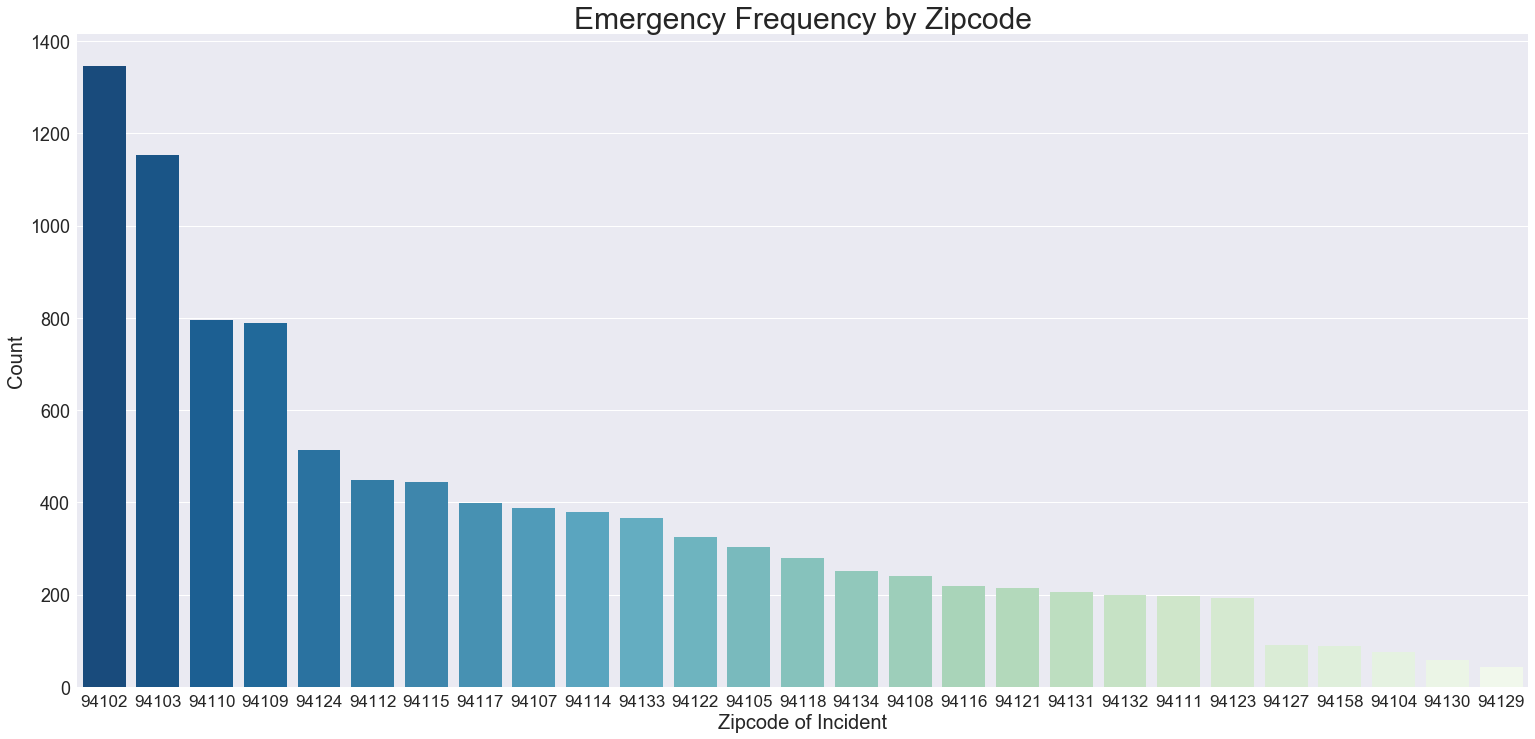

In [111]:
d = Counter(df['zipcode_of_incident'])
X = sorted(d, key=d.get, reverse= True)

sns.set(rc={'figure.figsize':(26,12)})
sns.countplot(x="zipcode_of_incident", data=dfc, palette="GnBu_r", order = X)
plt.title('Emergency Frequency by Zipcode', fontsize = 30)
plt.xlabel('Zipcode of Incident', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=18)

#plt.savefig('assets/zip_counts.png')

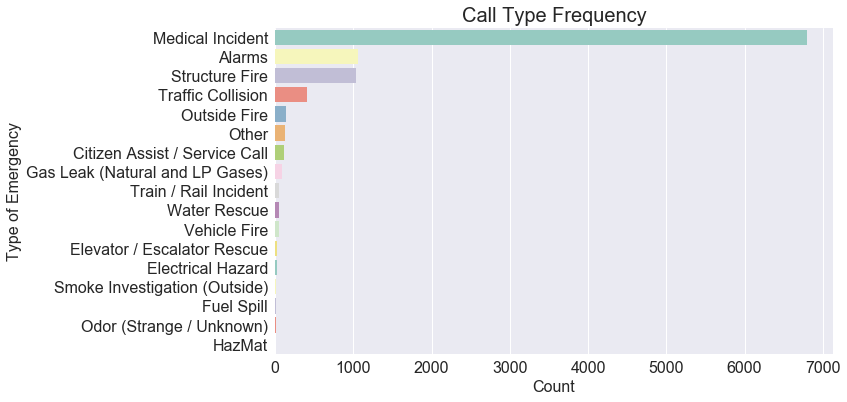

In [359]:
d = Counter(df['call_type'])
X = sorted(d, key=d.get, reverse= True)

sns.set(rc={'figure.figsize':(10,6)})
sns.countplot(y="call_type", data=dfc, palette="Set3", order = X)
plt.title('Call Type Frequency', fontsize = 20)
plt.xlabel('Count', fontsize = 16)
plt.ylabel('Type of Emergency', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.savefig('assets/ctt_counts.png')

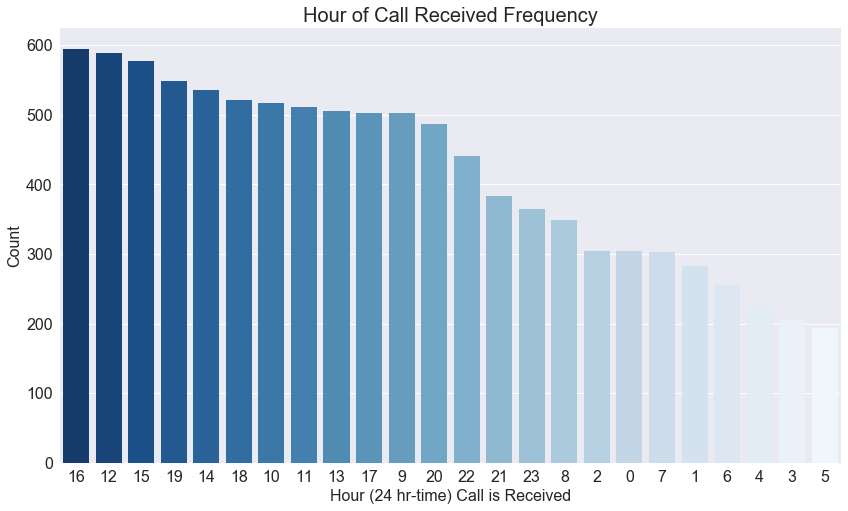

In [112]:
d = Counter(dfc['hour'])
X = sorted(d, key=d.get, reverse= True)

sns.set(rc={'figure.figsize':(14,8)})
sns.countplot(x="hour", data=dfc, palette="Blues_r", order = X)
plt.title('Hour of Call Received Frequency', fontsize = 20)
plt.xlabel('Hour (24 hr-time) Call is Received', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.savefig('assets/hour_counts.png')

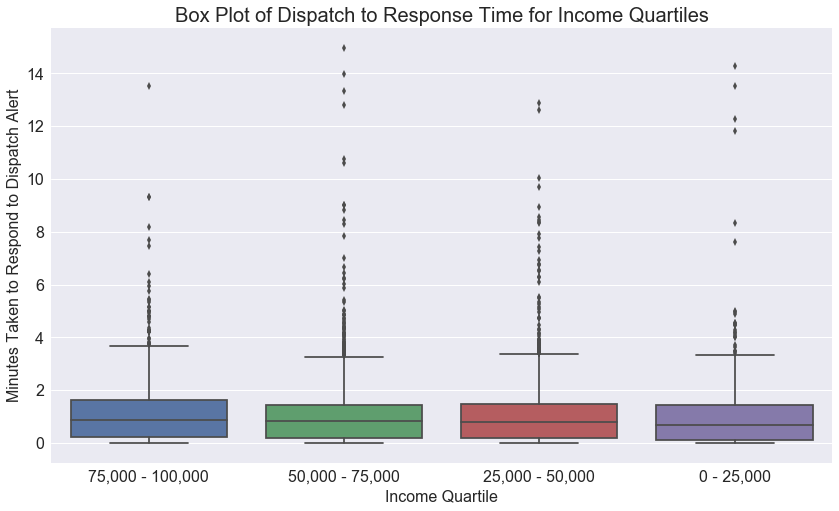

In [116]:
# Distribution of response time by Income Quartile
sns.set(rc={'figure.figsize':(14,8)})
sns.boxplot(x="zip_income_band", y="dispatch_to_response", data=temp, order = ['75,000 - 100,000', '50,000 - 75,000', '25,000 - 50,000','0 - 25,000'])
plt.title('Box Plot of Dispatch to Response Time for Income Quartiles', fontsize = 20)
plt.xlabel('Income Quartile', fontsize = 16)
plt.ylabel('Minutes Taken to Respond to Dispatch Alert', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('assets/box_income.png')

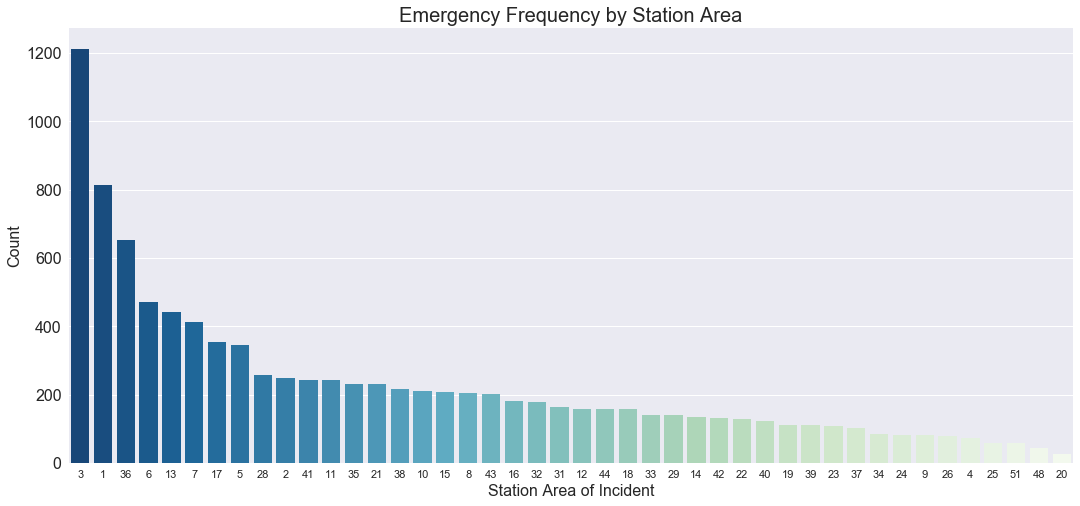

In [483]:
# Emergency Frequency by Station Area
d = Counter(df['station_area'])
X = sorted(d, key=d.get, reverse= True)

sns.set(rc={'figure.figsize':(18,8)})
sns.countplot(x="station_area", data=dfc, palette="GnBu_r", order = X)
plt.title('Emergency Frequency by Station Area', fontsize = 20)
plt.xlabel('Station Area of Incident', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=16)

plt.savefig('assets/sa.png')

In [487]:
dfc[dfc['zipcode_of_incident'] == 94103]['call_final_disposition'].value_counts()

Code 2 Transport              658
Fire                          224
Patient Declined Transport     66
No Merit                       62
Code 3 Transport               29
Against Medical Advice         28
Cancelled                      27
Unable to Locate               26
Other                          10
Medical Examiner                9
Gone on Arrival                 8
SFPD                            6
Name: call_final_disposition, dtype: int64

In [518]:
# Which zipcodes have the lowest amount of transportation incidents (vehicle fires, collisions, train accidents)
dfc[(dfc['call_type'] == 'Vehicle Fire') | (dfc['call_type'] == 'Traffic Collision') | (dfc['call_type'] == 'Train / Rail Incident')]['zipcode_of_incident'].value_counts()

94103    66
94105    50
94134    37
94110    36
94112    35
94122    31
94124    29
94102    25
94131    24
94109    21
94107    19
94114    18
94111    17
94117    17
94121    16
94118    15
94133    13
94130    10
94158     8
94116     7
94108     5
94115     4
94123     3
94127     2
94132     2
Name: zipcode_of_incident, dtype: int64

Now let's try to use specific hour instead of day portion, and station areas instead of zipcodes.

In [525]:
# Most likely dispatches, given an address (zipcode) and a specific hour 
d = {}
for zipcode in set(dfc['zipcode_of_incident']):
    times = []
    for hour in np.arange(0, 24, 1): 
        value_counts = dfc[(dfc.zipcode_of_incident == zipcode) & (dfc.hour == hour)]['call_type'].value_counts(normalize = True)
        try: 
            val1 = '1. ' +value_counts.index[0] + ' - ' + str(round(value_counts[0]*100, 0)) + '%;'
            if len(value_counts) == 1: 
                times.append(val1)
            elif len(value_counts) == 2: 
                val2 =  '2. ' + value_counts.index[1] + ' - ' + str(round(value_counts[1]*100, 0)) + '%;'
                times.append(val1 + '  ' + val2)            
            else:
                val2 =   '2. ' +value_counts.index[1] + ' - ' + str(round(value_counts[1]*100, 0)) + '%;'
                val3 =  '3. ' + value_counts.index[2] + ' - ' + str(round(value_counts[2]*100, 0)) + '%;'
                times.append(val1 + '  ' + val2 + '  ' + val3)
        except: 
            times.append('Unknown')
            continue
    d[zipcode] = times

print (d)

{94102: ['1. Medical Incident - 81.0%;  2. Structure Fire - 14.0%;  3. Alarms - 5.0%;', '1. Medical Incident - 59.0%;  2. Alarms - 23.0%;  3. Traffic Collision - 15.0%;', '1. Medical Incident - 51.0%;  2. Structure Fire - 28.0%;  3. Alarms - 8.0%;', '1. Medical Incident - 88.0%;  2. Alarms - 12.0%;', '1. Medical Incident - 67.0%;  2. Structure Fire - 25.0%;  3. Alarms - 8.0%;', '1. Medical Incident - 61.0%;  2. Structure Fire - 39.0%;', '1. Medical Incident - 54.0%;  2. Structure Fire - 27.0%;  3. Citizen Assist / Service Call - 11.0%;', '1. Medical Incident - 83.0%;  2. Other - 9.0%;  3. Structure Fire - 6.0%;', '1. Medical Incident - 80.0%;  2. Structure Fire - 13.0%;  3. Citizen Assist / Service Call - 7.0%;', '1. Medical Incident - 77.0%;  2. Alarms - 22.0%;  3. Outside Fire - 2.0%;', '1. Medical Incident - 64.0%;  2. Structure Fire - 20.0%;  3. Alarms - 12.0%;', '1. Medical Incident - 79.0%;  2. Alarms - 16.0%;  3. Structure Fire - 5.0%;', '1. Medical Incident - 69.0%;  2. Structu

In [529]:
# Most likely dispatches, given an address (zipcode) and a time 
d = {}
for sa in set(dfc['station_area']):
    times = []
    for day_portion in ['8 AM to 3 PM', '4 PM to 11 PM', '12 AM to 7 AM']: 
        value_counts = dfc[(dfc.station_area == sa) & (dfc.day_portion == day_portion)]['call_type'].value_counts(normalize = True)
        try: 
            val1 = '1. ' +value_counts.index[0] + ' - ' + str(round(value_counts[0]*100, 0)) + '%;'
            if len(value_counts) == 1: 
                times.append(val1)
            elif len(value_counts) == 2: 
                val2 =  '2. ' + value_counts.index[1] + ' - ' + str(round(value_counts[1]*100, 0)) + '%;'
                times.append(val1 + '  ' + val2)            
            else:
                val2 =   '2. ' +value_counts.index[1] + ' - ' + str(round(value_counts[1]*100, 0)) + '%;'
                val3 =  '3. ' + value_counts.index[2] + ' - ' + str(round(value_counts[2]*100, 0)) + '%;'
                times.append(val1 + '  ' + val2 + '  ' + val3)
        except: 
            times.append('Unknown')
            continue
    d[sa] = times

print (d)

{1: ['1. Medical Incident - 67.0%;  2. Alarms - 16.0%;  3. Structure Fire - 13.0%;', '1. Medical Incident - 81.0%;  2. Structure Fire - 7.0%;  3. Alarms - 7.0%;', '1. Medical Incident - 88.0%;  2. Alarms - 7.0%;  3. Structure Fire - 2.0%;'], 2: ['1. Medical Incident - 45.0%;  2. Alarms - 31.0%;  3. Structure Fire - 19.0%;', '1. Medical Incident - 51.0%;  2. Alarms - 24.0%;  3. Structure Fire - 22.0%;', '1. Medical Incident - 73.0%;  2. Structure Fire - 8.0%;  3. Traffic Collision - 6.0%;'], 3: ['1. Medical Incident - 73.0%;  2. Alarms - 14.0%;  3. Structure Fire - 7.0%;', '1. Medical Incident - 74.0%;  2. Structure Fire - 14.0%;  3. Alarms - 9.0%;', '1. Medical Incident - 72.0%;  2. Structure Fire - 13.0%;  3. Alarms - 8.0%;'], 4: ['1. Medical Incident - 53.0%;  2. Traffic Collision - 24.0%;  3. Alarms - 24.0%;', '1. Medical Incident - 50.0%;  2. Alarms - 43.0%;  3. Outside Fire - 4.0%;', '1. Medical Incident - 62.0%;  2. Alarms - 38.0%;'], 5: ['1. Medical Incident - 63.0%;  2. Structu

In [129]:
# Let's calculate which areas are experiencing the greatest increase in dispatch calls
dfc['dayofyear'] = dfc['received_timestamp'].apply(lambda x: x.dayofyear)
set(dfc['dayofyear'])

{13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}

In [130]:
df_13 = dfc[dfc.dayofyear == 13]
df_24 = dfc[dfc.dayofyear == 24]

In [132]:
df_13['zipcode_of_incident'].value_counts()

94102    110
94103     95
94109     70
94110     46
94107     44
94112     37
94114     37
94124     36
94134     35
94117     32
94123     30
94105     24
94122     20
94127     18
94108     16
94116     16
94115     16
94118     15
94121     15
94111     13
94131     12
94130     10
94129     10
94133     10
94158      8
94132      7
94104      1
Name: zipcode_of_incident, dtype: int64

In [133]:
df_24['zipcode_of_incident'].value_counts()

94102    144
94103     93
94109     84
94110     84
94105     39
94117     38
94107     35
94118     32
94131     25
94114     24
94122     23
94124     23
94133     22
94121     21
94115     21
94112     21
94134     19
94104     17
94108     17
94111     16
94123     13
94158     12
94116      7
94132      5
94127      2
Name: zipcode_of_incident, dtype: int64

In [138]:
dfc[dfc['station_area'] == 3]['call_type'].value_counts(normalize = True)

Medical Incident                   0.731245
Alarms                             0.111294
Structure Fire                     0.109646
Citizen Assist / Service Call      0.014015
Traffic Collision                  0.013190
Outside Fire                       0.008244
Elevator / Escalator Rescue        0.004946
Gas Leak (Natural and LP Gases)    0.004122
Vehicle Fire                       0.001649
Odor (Strange / Unknown)           0.000824
Other                              0.000824
Name: call_type, dtype: float64

In [139]:
dfc[dfc['zipcode_of_incident'] == 94102]['call_type'].value_counts(normalize = True)

Medical Incident                   0.704529
Structure Fire                     0.142539
Alarms                             0.109874
Traffic Collision                  0.018560
Citizen Assist / Service Call      0.010393
Other                              0.004454
Outside Fire                       0.003712
Elevator / Escalator Rescue        0.002227
Gas Leak (Natural and LP Gases)    0.001485
Fuel Spill                         0.000742
Odor (Strange / Unknown)           0.000742
Electrical Hazard                  0.000742
Name: call_type, dtype: float64

In [140]:
dfc[dfc['zipcode_of_incident'] == 94102]['call_type'].value_counts(normalize = True)

Medical Incident                   0.704529
Structure Fire                     0.142539
Alarms                             0.109874
Traffic Collision                  0.018560
Citizen Assist / Service Call      0.010393
Other                              0.004454
Outside Fire                       0.003712
Elevator / Escalator Rescue        0.002227
Gas Leak (Natural and LP Gases)    0.001485
Fuel Spill                         0.000742
Odor (Strange / Unknown)           0.000742
Electrical Hazard                  0.000742
Name: call_type, dtype: float64

In [141]:
dfc['call_type'].value_counts(normalize = True)

Medical Incident                   0.6791
Alarms                             0.1061
Structure Fire                     0.1029
Traffic Collision                  0.0410
Outside Fire                       0.0144
Other                              0.0129
Citizen Assist / Service Call      0.0114
Gas Leak (Natural and LP Gases)    0.0086
Train / Rail Incident              0.0055
Water Rescue                       0.0054
Vehicle Fire                       0.0045
Elevator / Escalator Rescue        0.0023
Electrical Hazard                  0.0021
Smoke Investigation (Outside)      0.0015
Odor (Strange / Unknown)           0.0010
Fuel Spill                         0.0010
HazMat                             0.0003
Name: call_type, dtype: float64

In [163]:
dfc[dfc['call_type'] == 'Structure Fire']['zipcode_of_incident'].value_counts(normalize = True)

94102    0.186589
94117    0.095238
94103    0.083576
94133    0.064140
94109    0.063168
94112    0.060253
94110    0.055394
94127    0.048591
94115    0.047619
94118    0.034985
94114    0.032070
94124    0.031098
94107    0.030126
94122    0.026239
94104    0.026239
94108    0.022352
94123    0.013605
94105    0.012634
94116    0.012634
94121    0.012634
94111    0.009718
94134    0.009718
94131    0.009718
94132    0.009718
94158    0.001944
Name: zipcode_of_incident, dtype: float64

In [151]:
dfc[dfc['zipcode_of_incident'] == 94110]['call_type'].value_counts(normalize = True)

Medical Incident                   0.699749
Alarms                             0.094221
Structure Fire                     0.071608
Traffic Collision                  0.042714
Outside Fire                       0.033920
Gas Leak (Natural and LP Gases)    0.017588
Other                              0.016332
Citizen Assist / Service Call      0.010050
Fuel Spill                         0.005025
Odor (Strange / Unknown)           0.002513
Vehicle Fire                       0.002513
Electrical Hazard                  0.002513
Smoke Investigation (Outside)      0.001256
Name: call_type, dtype: float64

In [155]:
dfc['call_type'].value_counts()

Medical Incident                   6791
Alarms                             1061
Structure Fire                     1029
Traffic Collision                   410
Outside Fire                        144
Other                               129
Citizen Assist / Service Call       114
Gas Leak (Natural and LP Gases)      86
Train / Rail Incident                55
Water Rescue                         54
Vehicle Fire                         45
Elevator / Escalator Rescue          23
Electrical Hazard                    21
Smoke Investigation (Outside)        15
Odor (Strange / Unknown)             10
Fuel Spill                           10
HazMat                                3
Name: call_type, dtype: int64

In [162]:
dfc[dfc['call_type'] == 'Gas Leak (Natural and LP Gases)']['zipcode_of_incident'].value_counts(normalize = True)

94124    0.209302
94110    0.162791
94109    0.093023
94123    0.081395
94133    0.069767
94117    0.058140
94115    0.058140
94114    0.058140
94134    0.046512
94122    0.034884
94107    0.034884
94104    0.034884
94102    0.023256
94132    0.011628
94118    0.011628
94108    0.011628
Name: zipcode_of_incident, dtype: float64

In [164]:
# Most likely dispatches, given an address (zipcode) and a time 
d = {}
for sa in set(dfc['station_area']):
    times = []
    for hr in np.arange(0, 24, 1): 
        value_counts = dfc[(dfc.station_area == sa) & (dfc.hour == hr)]['call_type'].value_counts(normalize = True)
        try: 
            val1 = '1. ' +value_counts.index[0] + ' - ' + str(round(value_counts[0]*100, 0)) + '%;'
            if len(value_counts) == 1: 
                times.append(val1)
            elif len(value_counts) == 2: 
                val2 =  '2. ' + value_counts.index[1] + ' - ' + str(round(value_counts[1]*100, 0)) + '%;'
                times.append(val1 + '  ' + val2)            
            else:
                val2 =   '2. ' +value_counts.index[1] + ' - ' + str(round(value_counts[1]*100, 0)) + '%;'
                val3 =  '3. ' + value_counts.index[2] + ' - ' + str(round(value_counts[2]*100, 0)) + '%;'
                times.append(val1 + '  ' + val2 + '  ' + val3)
        except: 
            times.append('Unknown')
            continue
    d[sa] = times

print (d)

{1: ['1. Medical Incident - 97.0%;  2. Outside Fire - 3.0%;', '1. Medical Incident - 93.0%;  2. Outside Fire - 7.0%;', '1. Medical Incident - 97.0%;  2. Other - 3.0%;', '1. Medical Incident - 85.0%;  2. Structure Fire - 15.0%;', '1. Medical Incident - 79.0%;  2. Alarms - 21.0%;', '1. Medical Incident - 100.0%;', '1. Medical Incident - 74.0%;  2. Alarms - 26.0%;', '1. Medical Incident - 76.0%;  2. Alarms - 14.0%;  3. Structure Fire - 10.0%;', '1. Medical Incident - 83.0%;  2. Alarms - 10.0%;  3. Structure Fire - 7.0%;', '1. Medical Incident - 84.0%;  2. Alarms - 16.0%;', '1. Medical Incident - 41.0%;  2. Structure Fire - 33.0%;  3. Alarms - 26.0%;', '1. Medical Incident - 61.0%;  2. Alarms - 39.0%;', '1. Medical Incident - 55.0%;  2. Structure Fire - 19.0%;  3. Traffic Collision - 14.0%;', '1. Medical Incident - 76.0%;  2. Alarms - 10.0%;  3. Traffic Collision - 7.0%;', '1. Medical Incident - 66.0%;  2. Structure Fire - 24.0%;  3. Alarms - 7.0%;', '1. Medical Incident - 77.0%;  2. Alarm